# 2023/3/13
* move analysis and test module from transformer(stable).ipynb to here

# 2023/3/14
* add bleu plot

# hyper-parameter
# Must change the origin_cuda and used_cuda for correct using

In [1]:
import torch

n_tokens = 37000
bos_id = 0
eos_id = 1
pad_id = 2

# below two hypeparameter is not need
# seq_len = 512
# batch_size = 8

d_model = 512
nhead = 8
dff = 2048
N = 6 # num of encoder/decoder layers
p_drop = 0.1

epsilon = 0.1

gpu_num = 1
warmup_steps = 4000*8//gpu_num

origin_cuda = "cuda:1" #training cuda
used_cuda = "cuda:0" # test cuda
device = torch.device(used_cuda if torch.cuda.is_available() else "cpu")


save_path = "checkpoint.tar"

# other parameter in train() and spm.SentencePieceTrainer.train()


/data2/zrs/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load tokenizer 

In [2]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("tokenizer.json")

# Load model

In [3]:
from torch import nn
import torch
import math
import os
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerDecoderLayer
from torch.nn import TransformerEncoder, TransformerDecoder


def generate_square_subsequent_mask(sz: int):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = p_drop, max_len: int = 40000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    def __init__(self,ntoken=n_tokens,d_model=d_model):
        super().__init__()
        
        self.d_model = d_model
        
        self.emb = nn.Embedding(ntoken,d_model,padding_idx=pad_id)
        self.pos_encoding = PositionalEncoding(d_model)
        
        encoder_layer = TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=dff,
                                               dropout=p_drop,activation='gelu')
        self.encoder = TransformerEncoder(encoder_layer,N)
        
        decoder_layer = TransformerDecoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=dff,
                                               dropout=p_drop,activation='gelu')
        self.decoder = TransformerDecoder(decoder_layer,N)
    
    def forward(self,src,tgt,tgt_mask,src_key_padding_mask,tgt_key_padding_mask):
        # src:[S,B] tgt:[T,B] tgt_mask:[T,T] src_key_padding_mask:[N,S] tgt_key_padding_mask:[N,T]
        # E=d_model
        src_emb = self.emb(src)*math.sqrt(self.d_model)  #src:[S,B] -> src_emb:[S,B,E]
        tgt_emb = self.emb(tgt)*math.sqrt(self.d_model)  #tgt:[T,B] -> tgt_emb:[T,B,E]
        src_emb = self.pos_encoding(src_emb)
        tgt_emb = self.pos_encoding(tgt_emb)
        
        # emb = embedding*sqrt(d_model) + PosEmbedding : [S,B,E]
        # tgt_mask:[T,T]
        
        src_hidden = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask) #[S,B,E]
        
        tgt_hidden = self.decoder(tgt_emb,src_hidden,tgt_mask=tgt_mask,\
                                  memory_key_padding_mask=src_key_padding_mask,\
                                  tgt_key_padding_mask=tgt_key_padding_mask) #[T,B,E]
                                 
        
        return F.linear(tgt_hidden,self.emb.weight) # Tying Weight [T,B,ntokens]
    
transformer_model = TransformerModel()
transformer_model.to(device)
if os.path.exists(save_path):

    data = torch.load(save_path, map_location={origin_cuda: used_cuda})
    transformer_model.load_state_dict(data['modules'][0])

# evaluate(transformer_model,batch_generator(dataset=test_de_en_pairs,gpu_num=gpu_num))

# Load best BLEU model

In [4]:
transformer_model.load_state_dict(torch.load('best_bleu.pt', map_location={origin_cuda: used_cuda}))

<All keys matched successfully>

# Vision

total steps: 1350000


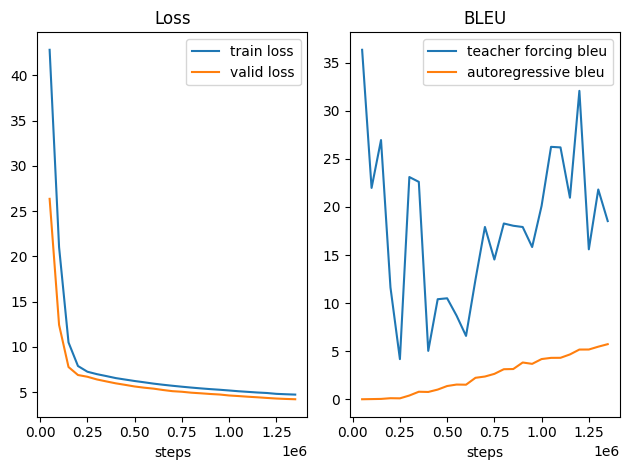

In [5]:
import matplotlib.pyplot as plt
import os

def paint():
    
    if os.path.exists(save_path):
        
        load_info = torch.load(save_path, map_location={origin_cuda: used_cuda}) #map_location={'cuda:3': 'cuda:1'}
        
        loss_list = load_info["train_loss_list"]
        valid_list = load_info["val_loss_list"]
        
        val_bleu_list = load_info["val_bleu_list"]
        val_auto_bleu_list = load_info["val_auto_bleu_list"]
        
        step_list = load_info["step_list"]
        steps = step_list[-1]

    else :
        return "Not exist checkpoint"
    
    print("total steps:",steps)
    
    plt.subplot(121)
    plt.title("Loss")
    plt.xlabel("steps")
    # plt.ylabel("loss")
    plt.plot(step_list,loss_list)
    plt.plot(step_list,valid_list) # [10:]
    plt.legend(["train loss","valid loss"])


    plt.tight_layout()
    
    plt.subplot(122)
    plt.title("BLEU")
    plt.xlabel("steps")
    # plt.ylabel("loss")
    plt.plot(step_list,val_bleu_list)
    plt.plot(step_list,val_auto_bleu_list)
    plt.legend(["teacher forcing bleu","autoregressive bleu"])


    plt.tight_layout()

paint()

# Test

In [6]:
from datasets import load_dataset
test_dataset = load_dataset("wmt14", 'de-en', split='test')

test_de_en_pairs = []
for i in range(len(test_dataset)):
    test_de_en_pairs.append((test_dataset[i]['translation']['de'],test_dataset[i]['translation']['en']))
    


Found cached dataset wmt14 (/data2/zrs/.cache/huggingface/datasets/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


In [7]:
import numpy as np
def translate(src,references):
    # src:str
    output = tokenizer.encode(src)
    
    src_ids = [output.ids] #[1,S] 
    src_padding_mask = [1-np.array(output.attention_mask)] #[1,S]
    tgt_ids = [[bos_id]] #[1,1] i.e [1,T]
    
    while tgt_ids[0][-1] != eos_id:
        if len(tgt_ids[0]) > len(output.ids) +50:
            break
        pred= transformer_model(torch.LongTensor(src_ids).t().contiguous().to(device),
                                torch.LongTensor(tgt_ids).t().contiguous().to(device),
                                generate_square_subsequent_mask(len(tgt_ids[0])).to(device),
                                torch.LongTensor(src_padding_mask).to(device),None)
        # [T,1,E]
        
        next_token = pred.argmax(dim=-1)[-1]
        #                      [T,1]
        
        # tgt_ids :<bos>       A         :[T]
        # pred    :  A    <next token>   :[T]
        
        tgt_ids[0].append(next_token.item())
    
    # src_ids:[S] tgt_ids=[T]
    tgt = tokenizer.decode(tgt_ids[0])
    print("\nsrc:",src)
    print("\npred:",tgt)
    #  candidate [allB,T(str)] # references [allB,1,T(str)]
    
    output = tokenizer.encode(tgt)
    candidate = [output.tokens]
    bleu = bleu_score(candidate,references)*100
    print(f"\nbleu:{bleu}")
    return bleu

In [8]:
from torchtext.data.metrics import bleu_score

total_bleu = 0.0
for i in range(len(test_de_en_pairs)):
    print("="*40)
    print("test"+str(i+1)+":")
    output = tokenizer.encode(test_de_en_pairs[i][1])
    total_bleu += translate(test_de_en_pairs[i][0],references=[[output.tokens]])
    print("ans:",test_de_en_pairs[i][1])

print(total_bleu/len(test_de_en_pairs))
print(total_bleu)


test1:


/tmp/ipykernel_36524/592119537.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  torch.LongTensor(src_padding_mask).to(device),None)



src: Gutach: Noch mehr Sicherheit für Fußgänger

pred:  The safety of the security of the safety of security.

bleu:0.0
ans: Gutach: Increased safety for pedestrians
test2:

src: Sie stehen keine 100 Meter voneinander entfernt: Am Dienstag ist in Gutach die neue B 33-Fußgängerampel am Dorfparkplatz in Betrieb genommen worden - in Sichtweite der älteren Rathausampel.

pred:  In the newel-h-in- Sel-f-d-f-in- der 100-to- der 100-f-in- der 100- der 100-f- new- in the new- und der 100-f- der 100-f-in- nicht in the new-mail.

bleu:0.0
ans: They are not even 100 metres apart: On Tuesday, the new B 33 pedestrian lights in Dorfparkplatz in Gutach became operational - within view of the existing Town Hall traffic lights.
test3:

src: Zwei Anlagen so nah beieinander: Absicht oder Schildbürgerstreich?

pred:  For this reason, or a: the room in a room or a few minutes?

bleu:0.0
ans: Two sets of lights so close to one another: intentional or just a silly error?
test4:

src: Diese Frage hat Gutachs


src: Ein weiteres Radarsensor prüft, ob die Grünphase für den Fußgänger beendet werden kann.

pred:  The most of the number of the most important to the most important to be used in the way.

bleu:0.0
ans: An additional radar sensor checks whether the green phase for the pedestrian can be ended.
test23:

src: "Sollte eine Gruppe oder gehbehinderte Menschen über die Straße gehen, wird die Grünphase verlängert, es kommt also jeder sicher über die Fahrbahn", erklärte Arnold.

pred:  In the case of the fact that is a very important to the people of the people, which is a number of the people who are not a great deal with the people.

bleu:0.0
ans: "If a group of people or if disabled persons are crossing the street, the green phase is extended, thus ensuring that everyone gets safely across the street," explained Arnold.
test24:

src: Natürlich müsse der Autofahrer hier als Partner mitdenken und die Fahrbahn beobachten.

pred:  The most of the European Parliament and the most important th


src: US-amerikanische Straßenplaner sind auf der Suche nach einer Geldquelle, um das verfallende Highway-System zu reparieren, und glauben die Lösung in einem kleinen schwarzen Kasten gefunden zu haben, der im Armaturenbrett jedes Autos Platz findet.

pred:  The only a new-in- is to the US-'s a great deal with the in the world, which is a very important, and the that is a very much more than a great deal with the most of the in the world.

bleu:0.0
ans: As America's road planners struggle to find the cash to mend a crumbling highway system, many are beginning to see a solution in a little black box that fits neatly by the dashboard of your car.
test42:

src: Die Geräte, die jeden gefahrenen Kilometer aufzeichnen und die Informationen an die Behörden melden, sind Kernpunkt eines kontroversen Versuchs von Washington und den Planungsbüros der Bundesstaaten, das veraltete System zur Finanzierung US-amerikanischer Straßen zu überarbeiten.

pred:  The information is a new information on the


src: Bürokraten bezeichnen es als meilenbasierte Benutzergebühr.

pred:  In the view of the new work.

bleu:0.0
ans: Wonks call it a mileage-based user fee.
test63:

src: Es überrascht nicht, dass die Idee bei städtischen Liberalen Anklang findet, denn die Steuer ließe sich beispielsweise dazu einsetzen, das Fahrverhalten so zu beeinflussen, dass Staus und klimaschädliche Abgase reduziert werden.

pred:  It is not possible to be a very important that we are not to do so that the number of the most important and the time of the European Union is not in the way, and that they are not to be able to the.

bleu:0.0
ans: It is no surprise that the idea appeals to urban liberals, as the taxes could be rigged to change driving patterns in ways that could help reduce congestion and greenhouse gases, for example.
test64:

src: Die kalifornischen Planer setzen auf das System bei der Ausarbeitung von Strategien, mit denen die ambitionierten, gesetzlich verankerten Ziele des Bundesstaats zum Klima


src: Als der Test anlief, warnte die ACLU von Nevada auf ihrer Website: „Es wäre relativ einfach, die Fahrtenschreiber in ausgewachsene Überwachungsgeräte zu verwandeln.“

pred:  In addition to the most of the new and the "C" on the in the world in the main main the most of the to be in the to the a new, to be able to the most of the.

bleu:0.0
ans: As the trial got underway, the ACLU of Nevada warned on its website: "It would be fairly easy to turn these devices into full-fledged tracking devices."
test84:

src: Es bestehe keine Notwendigkeit, eine gigantische, sperrige technologische Infrastruktur aufzubauen, die unweigerlich dazu verwendet werden würde, Daten über die täglichen Bewegungen von Einzelpersonen zu erfassen.

pred:  It is not a need to be a way to the need to be used to be a need to be used to the data.

bleu:0.0
ans: There is no need to build an enormous, unwieldy technological infrastructure that will inevitably be expanded to keep records of individuals' everyday com


src: Eine zusätzliche einmalige Gebühr oder eine jährliche Abgabe könnte Autofahrern mit Hybridfahrzeugen oder anderen Fahrzeugen, die wenig Benzin verbrauchen, auferlegt werden, sodass auch diese einen fairen Anteil zahlen.

pred:  The other or the other words of the other, a number of the other Member States, or a number of the other words, in the other countries, or a number of the other words, or other countries.

bleu:0.0
ans: An extra one-time or annual levy could be imposed on drivers of hybrids and others whose vehicles don't use much gas, so they pay their fair share.
test103:

src: „Es gibt keinen Grund für eine Operation, wenn ein Aspirin auch ausreicht“, erläutert Randy Rentschler, der Leiter für Gesetzgebung und öffentliche Angelegenheiten der Kommission.

pred:  A new Commission is a very important to the Commission for the Commission and the is a new and that is a result of the Commission.

bleu:0.0
ans: "There is no need for radical surgery when all you need to do is t


src: Im Förderzentrum Hochschwarzwald ging er zusammen mit den Geschäftsführenden Schulleitern der Beruflichen Schulen sowie des Kreisgymnasiums und den Elternbeiratsvorsitzenden dieser wichtigen Frage nach.

pred:  The most important economic and the most important of the most of the most important role of the most important and the most of the most important and the most important issue of the most important and the most important and the most of the question of the most important to the most important.

bleu:0.0
ans: In the Hochschwarzwald Support Centre, he addressed this important question alongside the executive principals of the vocational colleges and the district grammar school and the chairs of the parents' council.
test128:

src: "Bildung ist ein wichtiger Standortfaktor", unterstrich Claudia Stehle, Direktorin der Hans-Thoma-Schule, die das vernetzte Schulprojekt Bildungszentrum Hochschwarzwald vorstellte.

pred:  In the most of the a new, the most of the most important, t


src: Mittlerweile findet dieser Nachmittag im Pflegeheim St. Josef statt.

pred:  The this is the in the this House.

bleu:0.0
ans: The coffee afternoon is now held in the St. Josef nursing home.
test146:

src: Die Heimbewohner freuten sich auf die leckeren Kuchen und Torten.

pred:  The hotel is the most important to the most important and the most of the hotel.

bleu:0.0
ans: The residents of the home were delighted with the delicious cakes and tarts.
test147:

src: Später gab es Wurstsalat.

pred:  Thealal is theal of theal.

bleu:0.0
ans: Later on, a sausage salad was provided.
test148:

src: Mit gängigen Melodien unterhielten Silvia Kimmich-Bantle und ihr Vater Karl Kimmich.

pred:  The new and the K--f-h-to-in-t-B-B-B-B-f-f-B-B- der- der-f- der.

bleu:0.0
ans: Silvia Kimmich-Bantle and her father Karl Kimmich entertained those in attendance with popular tunes.
test149:

src: Die über 100 Jahre alte Natursteinmauer als vordere Abgrenzung des vor der Sanierung stehenden alten Schu


src: Özdemir will Jazzausbildung in Stuttgart erhalten

pred:  Dieirzzzz wird in deririr-K- und in der m².

bleu:0.0
ans: Özdemir wants jazz training in Stuttgart
test163:

src: In die anhaltenden Diskussionen um die Zukunft der Musikhochschulen in Baden-Württemberg hat sich nun auch Cem Özdemir, Bundesvorsitzender der Grünen, eingeschaltet.

pred:  In the case of the most important, the most of the new future, the in the European Parliament has been in the most important.

bleu:0.0
ans: Cem Özdemir, Federal Chairman of the Green Party, has now engaged in the ongoing discussions regarding the future of the Baden-Wuerttemberg Music Academy.
test164:

src: "Ich halte es für falsch, die ganzheitliche Ausbildung in der Musikhochschule Stuttgart aufzugeben", sagte Özdemir den "Stuttgarter Nachrichten".

pred:  "M" "M" is the "A- "C" in the "The in the "C"" in the "C" in the " " " "C""" of the " "B" in the " "M" in the " "C"" in the "The "M" for the "S""" and the " "F" in the "M " "

bleu:0


src: Der Tunnel hat einen Querschnitt von 1,20 Meter Höhe und 90 Zentimeter Breite.

pred:  The 1.20 of 1.20, and the 1.

bleu:0.0
ans: The tunnel has a cross-section measuring 1.20 metres high and 90 centimetres across.
test184:

src: Er wäre damit auch geeignet gewesen, um die illegale Einwanderung Richtung USA zu fördern.

pred:  It would also be clear that the US would be the US.

bleu:0.0
ans: It would thus be suitable to assist illegal immigration into the USA.
test185:

src: Zwei der Verdächtigen wurden in Zusammenhang mit dem Kokain-Fund festgenommen.

pred:  TheF-F-FF-F-f--F-F-F-f-f-F- der in the number of theF.

bleu:0.0
ans: Two of the suspects were detained in conjunction with the cocaine find.
test186:

src: Der Dritte, ein Mexikaner, wurde wegen des beschlagnahmten Marihuanas gefasst.

pred:  The Mar Mar, a great deal of the Maru, is a very important.

bleu:0.0
ans: The third, a Mexican, was detained due to the seizure of the marijuana.
test187:

src: Allen dreien droht 


src: Diese wird im Jubiläumsjahr fertig und eingeweiht, der offizielle Termin ist am letzten Septemberwochenende, am 27. und 28. September.

pred:  The September and the September and the September of September, and the September of the September September and the September, and the September and the in the September of the most of September and the September.

bleu:0.0
ans: This venue will be completed and inaugurated in the anniversary year, with the official date set for the last weekend in September, on 27 and 28 September.
test210:

src: Anlässlich des Geisinger Stadtjubiläums wird auch noch eine neue Chronik herausgebracht.

pred:  The new new new and the new new new new in the new and the new city.

bleu:0.0
ans: On the occasion of the Geisingen town anniversary, a new chronicle will also be published.
test211:

src: "Es soll aber eine Chronik nicht nur von Geisingen selbst werden, sondern ein gedrucktes Werk über das Geisingen von heute, das eben aus Geisingen, Kirchen-Hausen,


src: Dort plant die Stadt, in Höhe des dortigen Tunnelmundes westlich der Bahngleise eine Ausbuchtung zu bauen.

pred:  The in the a new of the in the city of the the city of the in the in the city of the city of the world.

bleu:0.0
ans: At the crossing, the town is planning to increase the height of the mouth of the tunnel to the west of the railway line.
test230:

src: Dort könnten auch größere Fahrzeuge, zum Beispiel solche, die Langholz transportieren, bei Gegenverkehr stehen, ohne die Gleise blockieren zu müssen.

pred:  In addition to the G) of our work is also to be in the G.

bleu:0.0
ans: Larger vehicles, for example those that transport long logs, would be able to wait there in the event of oncoming traffic, without having to block the railway line.
test231:

src: Grießhaber schlug daher vor, eine erforderliche Stützmauer so zu konstruieren, dass die Stadt die anschließende Straße zu gegebener Zeit verbreitern könne, um einen reibungslosen Verkehrsfluss zu gewährleisten.

p


src: Da sowohl die Holzabfuhr als auch das Abbiegen im aktuellen Ausbauzustand funktionierten, solle man dem Umbau des Bahnübergangs nicht zustimmen, argumentierte Haas.

pred:  In the case of the new and the (B.

bleu:0.0
ans: Because both the transportation of wood and turning are both possible as things are, the reconstruction of the railway crossing should not be consented to, argued Haas.
test245:

src: Auch sei an dieser Stelle das Risiko einer Kollision des Zuges mit einem auf dem Übergang stehenden Fahrzeug deutlich geringer als an den anderen Bahnübergängen, weil sich direkt daneben der Haltepunkt Mitte befinde, zu dem eine gute Sichtverbindung bestehe.

pred:  The the a number of the most important this is a very good for the most of the out of the other other than a new, which is a very good, as a very good and the other of the new Member States.

bleu:0.0
ans: At this point, the risk of a train collision with a vehicle positioned on the crossing is considerably lower than 


src: In den nächsten Tagen soll eine endgültige Entscheidung durch das wissenschaftliche Programmkomitee fallen.

pred:  In the next to the next next year, the next time is to be a good for the next next year.

bleu:0.0
ans: Over the coming days, a final decision is to be made by the Scientific Programme Committee.
test266:

src: Insgesamt vier große Fragen hat die Esa ausgewählt, auf welche die Missionen des 2007 initiierten Programms "Cosmic Vision" Antworten finden sollen.

pred:  The new "C" is the most important to the new Member State of the new questions of the "C" on the "C"" on thea" of the questions of the new.

bleu:7.888035476207733
ans: In total, four main questions were chosen by the ESA, to which the missions of the "Cosmic Vision" programme, initiated in 2007, are to find the answers.
test267:

src: Was sind die Bedingungen für die Entstehung von Planeten und Leben?

pred:  What are the conditions for the life of the conditions?

bleu:30.943732141934888
ans: What are t


src: Das Weltall bietet viele Möglichkeiten, Materie unter extremen Bedingungen zu studieren und so zu untersuchen, ob die uns bekannten Naturgesetze dort immer noch gültig sind.

pred:  This is why the world are many of the world, and the world are still in the world.

bleu:0.0
ans: Outer space offers many possibilities for studying substances under extreme conditions and thus examining whether the laws of nature, as known to us, are still valid there.
test287:

src: Vielleicht finden sich auch Abweichungen, die den Physikern den Weg zu einer neuen Theorie weisen könnten, unter deren Dach sich alle bekannten Naturgesetze vereinen lassen.

pred:  The newing of the new new, which is a new, which is also a newing of the new and the new, which is also a new.

bleu:0.0
ans: There may also be deviations that could show physicians the path to a new theory, under the umbrella of which all known natural laws could be united.
test288:

src: Wie ist das Universum entstanden und woraus besteht e


src: Snowden bereit, mit Deutschland in Bezug auf US-Überwachung zu „kooperieren“

pred:  The US-in-in-based “C” in Germany, in the USA of the new and the world.

bleu:0.0
ans: Snowden ready to "cooperate" with Germany over US surveillance
test305:

src: Edward Snowden, der Whistleblower des US-amerikanischen Geheimdienstes, hat erklärt, er sei bereit, nach Berlin zu reisen und vor dem deutschen Bundestag auszusagen, wenn die amerikanische National Security Agency und ihr Direktor Keith Alexander keine Antworten über ihre Aktivitäten geben.

pred:  The Berlin was a few days in the Berlin, and the Berlin, when he has to the Berlin to the US, and the Berlin of the US and the Berlin of the US, and the Berlin, and the Berlin.

bleu:0.0
ans: Edward Snowden, the US intelligence whistleblower, has declared that he is willing to travel to Berlin to give evidence to the German parliament if the US National Security Agency and its director Keith Alexander fail to provide answers about its activ


src: In seinem Brief macht Snowden den deutschen Behörden ein Angebot der Zusammenarbeit, „wenn die Schwierigkeiten rund um die humanitäre Situation gelöst wurden“.

pred:  In the way of the situation, the cooperation is the most important in the way of the authorities to the situation in the cooperation.

bleu:0.0
ans: The letter extends an offer to cooperate with German authorities "when the difficulties of this humanitarian situation have been resolved."
test322:

src: Frontier Airlines erhebt Gebühren für Handgepäck

pred:  The most important in the most important for the time.

bleu:0.0
ans: Frontier Airlines to charge for carry-on baggage
test323:

src: Frontier Airlines plant, bis zu 100 US-Dollar von Passagieren zu verlangen, die auf ihrem Flug Handgepäck verstauen möchten.

pred:  The 100% of the 100 years of the US-in-in-s, is not to be a.

bleu:0.0
ans: Frontier Airlines plans to charge up to $100 for passengers to store carry-on luggage on board their flight.
test324:

src


src: Spirit Airlines Inc. verlangte vor drei Jahren als Erste Gebühren für Handgepäck und später folgte Allegiant Air, ebenfalls ein Billigflieger.

pred:  The three years of the three-in-f-f-to-f- three-up and three years ago.

bleu:0.0
ans: Spirit Airlines Inc. started the first carry-on fee three years ago, and fellow discounter Allegiant Air later followed.
test343:

src: Die einzige andere Fluggesellschaft mit einer derartigen Gebühr sei die ungarische Wizz Air, erklärte der Airline-Berater Jay Sorensen, der die Zusatzgebühren aufmerksam verfolgt.

pred:  The other in the fact that the other hand is the other countries of the world's in the other.

bleu:0.0
ans: The only other airline with such a fee is Hungary's Wizz Air, said airline consultant Jay Sorensen, who closely tracks add-on fees.
test344:

src: Er schätzte in einem Bericht vom Dezember 2011, dass die Handgepäckgebühr Spirit jährlich 50 Millionen US-Dollar einbringe.

pred:  The report is a million of the report that a


src: Republic hat versucht, im Rahmen des Verkaufs der Gesellschaft die Finanzen von Frontier in den Griff zu bekommen.

pred:  In society, the society has in the society of the society in society, the society in society.

bleu:0.0
ans: Republic has been trying to fix Frontier's finances as part of selling the airline.
test364:

src: Sprichwörter kommen aus der Bibel

pred:  The most of theel of theel of the most of theel.

bleu:0.0
ans: Sayings come from the Bible
test365:

src: Gut 40 Frauen besuchten das letzte Frauenfrühstück dieses Jahres in der evangelischen Kirchengemeinde Bisingen.

pred:  The women is the women in the women in the women of the women in the women.

bleu:0.0
ans: At least 40 women attended the last women's breakfast of the year, in the Evangelical Parish of Bisingen.
test366:

src: Thema des Tages im Gemeindehaus waren "Sprichwörter aus der Bibel" und "Redewendungen aus dem Mittelalter".

pred:  "S" in the "S" and the most of the "S" in the most important".

bl


src: NSA erklärt, ein „interner Fehler“ und nicht Hacker seien Schuld am Crash der Website

pred:  The “SA” is a “The-Ser- Antwort” and the “b-mail of the three-S-s and the “Theer” and aer.

bleu:0.0
ans: NSA Blames "Internal Error," Not Hackers, For Website Crash
test384:

src: Die schattenhafte National Security Agency erklärte am späten Freitag, ein Fehler habe ihre öffentliche Website einige Stunden lahmgelegt und nicht Hacker, wie online behauptet wurde.

pred:  The most important and the European Parliament has been a great deal of the most important and the time.

bleu:0.0
ans: The shadowy National Security Agency said late Friday that it was a glitch that brought down its public website for a few hours, not hackers as some claimed online.
test385:

src: „NSA.gov war heute Nacht einige Stunden lang nicht erreichbar, da während eines geplanten Updates ein interner Fehler aufgetreten ist“, erläuterte die Spionageagentur in einer per E-Mail versandten Meldung.

pred:  The in the i


src: Mitte Dezember beginnt dort die Wintersaison.

pred:  The December of the December of the Win Win-in-to-to-o.

bleu:0.0
ans: The Winter season within the industry begins in mid-December.
test402:

src: Den ganzen Hintergrundbericht dazu finden Sie im Allgäuer Anzeigeblatt vom 31.10.2013 (Seite 33).

pred:  All the (10) is a new in the 31.

bleu:0.0
ans: The complete background report on this can be found in the "Allgäuer Anzeigeblatt" newspaper dated 31/10/2013 (page 33).
test403:

src: Gewinneinbußen bei Bombardier nach Rückgang bei Lieferzahlen und Aufträgen

pred:  B. The new and B.

bleu:0.0
ans: Bombardier profit dips as plane deliveries, orders fall
test404:

src: Der kanadische Flugzeug- und Eisenbahnhersteller Bombardier Inc meldete am Donnerstag einen 15-prozentigen Rückgang des Nettogewinns, nachdem er durch rückläufige Bestellungen und Auslieferungen bei Flugzeugen im dritten Quartal sowie Vertragsprobleme in der Eisenbahnsparte unter Druck geraten war.

pred:  The in 


src: „Das Testflugzeug ist nicht länger am Boden geblieben als erwartet“, sagte Beaudoin bei einer Telefonkonferenz und fügte hinzu, während der Standzeit des Flugzeugs seien Bodentests und Software-Updates angesetzt gewesen.

pred:  The new and the software of the software of the new and the software of the software and the most of the software, is not a new and the most of the most of the world.

bleu:0.0
ans: "The test plane didn't stay on the ground longer than anticipated," Beaudoin said in a conference call, adding that ground tests and software updates were scheduled during the plane's downtime.
test419:

src: Jeder Hersteller plant anders.

pred:  The hotel is a very good.

bleu:0.0
ans: Every manufacturer schedules it in a different way.
test420:

src: Wir haben beschlossen, einen ersten Flug zu unternehmen und dann einen Überarbeitungszeitraum anzuhängen, was wir auch getan haben.

pred:  We have a first of the first time, and we have a first time to have a first time.

bleu


src: Im nachmittäglichen Handel am Donnerstag gab die Bombardier-Aktie um 8,5 Prozent nach und lag bei 4,83 kanadischen Dollar, nachdem auch angekündigt wurde, dass der Google-Finanzvorstand Patrick Pichette in den Vorstand wechseln wird.

pred:  The 4-f-5- der B.5-A-5- nicht nur in der 8-in-A, die in the fact that is a large- der B.

bleu:0.0
ans: Shares of Bombardier, which also announced that Google Inc Chief Financial Officer Patrick Pichette would join the board, were down 8.5 percent at C$4.83 in mid afternoon trading on Thursday.
test440:

src: Die brasilianische Embraer SA, der weltweit drittgrößte kommerzielle Flugzeughersteller und Bombardiers engster Rivale, meldete am Donnerstag einen zehnprozentigen Rückgang des Quartalsgewinns.

pred:  The most important, is a very important to the world, the world-in-f-s, a very important, and the world, and the world.

bleu:0.0
ans: Brazil's Embraer SA, the world's third-largest commercial planemaker and Bombardier's closest rival, rep


src: Der LAX-Flughafen von Los Angeles ist einer größten Flughafen der USA.

pred:  The US-XX is the "FX" by the EuropeanX-X-X-X-t.

bleu:0.0
ans: The Los Angeles LAX airport is one of the largest airports in the USA.
test466:

src: Kokainabhängiger Anwalt, der Drogenboss vor polizeilicher Ermittlung warnte, muss ins Gefängnis

pred:  Theb, thebbbb, theb, and theb of the most important.

bleu:0.0
ans: Cocaine-addict lawyer who tipped off Mr Big about police investigation is jailed
test467:

src: Basharat Ditta, 42, gab Informationen an Unterweltgröße Neil Scarborough weiter

pred:  The Member States of the information is not only to the most of the information.

bleu:0.0
ans: Basharat Ditta, 42, would feed information to crime lord Neil Scarbrough
test468:

src: Der Anwalt hatte Angst, seine heimliche Drogenabhängigkeit könnte ans Licht kommen

pred:  The first of the his was the most of the his year.

bleu:0.0
ans: The solicitor feared his secret drug addiction would be exposed
test4


src: Zwei Ermittlungsbeamte folgten dem Verdächtigen und sahen, wie er zu Dittas Haus ging und dort die Drogen mit einer Reinheit von 60 Prozent in einem schwarzen Golfhandschuh unter die Mülltonne des Anwalts legte.

pred:  In addition to the most of the in the a and the a number of the a new and the a few days of the in the most of the most of the in the most of the most of the a.

bleu:0.0
ans: Two detectives trailed the suspect and spotted him arriving at Ditta's house in and was seen to place the drugs which had a purity of 60 per cent under the lawyer's bins in a black golf glove.
test483:

src: Kurz nachdem er die Drogen abgeliefert hatte, telefonierte Scarborough regelmäßig mit Ditta, der sich beim Abendessen im Fußballstadion der Blackburn Rovers in Ewood Park befand.

pred:  The only was the in the R Ry of the only in the R R R.

bleu:0.0
ans: Soon after the drop off, Scarborough was in regular phone contact with Ditta who had been out at the dinner at the Blackburn Rovers f


src: Doch nach der Anhörung sagte Superintendent Lee Halstead von der Polizei in Lancashire: „Herr Ditta hat den Schritt von einem Strafverteidiger zu einem Kriminellen in dem Moment getan, als er anfing, Drogen von organisierten Kriminellen zu erwerben.“

pred:  The a new in the L. The "in" of the a newing of the in the a 's' .

bleu:0.0
ans: But after the hearing Supt Lee Halstead from Lancashire Police said: "Mr Ditta turned from criminal solicitor to a criminal himself the moment he started obtaining drugs from organised criminals."
test500:

src: Seine Kokainabhängigkeit führte zu einer hoffnungslosen Kompromittierung und machte ihn empfänglich für die Motive führender Mitglieder der organisierten Kriminalität, die ihn beauftragten, wertvolle Informationen über polizeiliche Ermittlungen einzuholen.

pred:  The the information is a number of the information on the information and the information of the information on the information on the information on the information of the inf


src: Die Messe wird im Rahmen der Gottesdienste aufgeführt, wie der Auftraggeber Johann Philipp Neumann es im Sinn hatte.

pred:  The in the most of the new in the most of the in the (e) is the most of the the most important.

bleu:0.0
ans: Patron Johan Philipp Neumann has in mind for the mass to be performed as part of the church services.
test515:

src: Unter der Leitung von Hermann Schneider wird der Chor von der Bläsergruppe des Musikvereins Frohsinn Tennenbronn und Noemi Lokodi an der Orgel begleitet.

pred:  Fiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii.

bleu:0.0
ans: Under the directorship of Hermann Schneider, the choir will be accompanied by the wind ensemble of the Frohsinn Tennenbronn Music Society, and by Noemi Lokodi on the organ.
test516:

src: Haslach: Skepsis weicht zusehends Zuversicht

pred: lll: Thellllllll.

bleu:0.0
ans: Haslach: Scepticism visibly gives way to confidence
test517:

src: Mit den Wahlen zum Pfarrgemeinderat 2015 wird sich beispielsw


src: Praktische Erfahrung mit einem gemeinsamen Gremium für fünf Pfarreien schilderte Barbar Ritter, die Vorsitzende des Gremiums in der Seelsorgeeinheit Schutterwald-Neuried.

pred:  The second-P-t-t is a new in the R-t-t-in- R-d-s of the R-in-in-up of the (C-f-t- der (the-) of the most of the most of the in the in theb-up-f- der R- und der "S.

bleu:0.0
ans: Barbar Ritter, Chair of the Committee in the Schutterwald-Neuried pastoral care unit, has practical experience of a joint committee for five parishes.
test534:

src: Sie hatten sich 2006 zur Aufgabe gemacht, "Eins werden, fünf bleiben" und mussten feststellen, dass das gar nicht so einfach ist.

pred:  You are not the 2006, 'EE' s 2006 and not the 2006' s 2006.

bleu:0.0
ans: In 2006 she set herself the task, "Become one, remain five" and came to realise that the task is really not that simple.
test535:

src: Die Gremien der Haslacher Seelsorgeeinheit machten sich dann daran, die Fragen zur künftigen Zusammensetzung und Größe de


src: Die Wartezeit müsse aber "angemessen" sein, was von Fall zu Fall unterschiedlich ausgelegt werden könne.

pred:  The case of the case of the case of the case, but it is "C case" to be a.

bleu:0.0
ans: The waiting time must, however, be "appropriate", which can be interpreted differently on a case-to-case basis.
test554:

src: Becker rät, mindestens fünf Minuten auszuharren, bevor von einer Funktionsstörung der Ampel auszugehen ist.

pred:  The hotel is a number of the in the (C- is a few minutes from the most important, a few minutes, which is a.

bleu:0.0
ans: Becker advises that you wait at least five minutes before a fault with the traffic lights can be assumed.
test555:

src: Wer die Fahrt trotz Rotlichts fortsetzt, müsse sich jedoch im Klaren darüber sein, dass er für einen dadurch verursachten Unfall die volle Schuld trägt.

pred:  However, the fact that the new and the new in the new in the area of the most important to the new and the form of the world.

bleu:0.0
ans: An


src: "So ein Werk schüttelt man nicht einfach aus dem Ärmel", lobte Gerster mit Blick auf die Jahresrechnung.

pred:  The the most of the "C" in the "C" on the year" and the world.

bleu:0.0
ans: "A job like this is not something you achieve overnight," said Gerster in praise of the annual financial statement.
test575:

src: Er und die Gemeinderäte freuten sich sichtlich über die guten Zahlen.

pred:  The new and the in the most of the and the and the most important, are the most of the in the way.

bleu:0.0
ans: He and the Town Councillors are clearly delighted with the good figures.
test576:

src: Es mag paradox klingen, doch genau diese guten Zahlen könnten die Bürger bald teuer zu stehen kommen.

pred:  It is a good citizens to the citizens of the citizens.

bleu:9.92931712038939
ans: It may sound like a paradox, but it is precisely these good figures that could soon work out expensive for the citizens.
test577:

src: Durch die gute Finanzlage konnte die Gemeinde in der Vergangenh


src: Der Männergesangverein Betra sang ebenfalls klassische Chorlieder wie "Jägerwerben" von Julius Wengert, "Weit, weit weg" von Hubert Goisern sowie das Volkslied "Wann du durchgehst durchs Tal".

pred:  The "W" by the "W" and "W" of the "W" by the "W" of the "W" by the "W" of the "W".

bleu:0.0
ans: The Betra Male Voice Choir also sang classic choral pieces such as "Jägerwerben" by Julius Wengert, "Weit, weit weg" by Hubert Goisern and the folk song "Wann du durchgehst durchs Tal".
test593:

src: Der Liederkranz Salzstetten sorgte mit seinem gemischten Chor und seiner Frauengruppe - dem "Impulschor" - für die Frauenquote des Festes.

pred:  The women is a very important and the most important women in the women.

bleu:0.0
ans: With its mixed choir and its ladies' ensemble - the "Impulschor" (Impulse Choir), the Salzstetten Choral Club ensured that the female quota was fulfilled at the festival.
test594:

src: Der gemischte Chor entführte mit der neapolitanischen Volksweise "Santa L


src: „Wir befinden uns in einer beängstigenden Lage und man darf sich fragen: Was hält das Parlament davon ab, morgen einfach die richterliche Unabhängigkeit abzuschaffen?“, war in der Zeitung zu lesen, die den Gesetzesentwurf für nicht verfassungsgemäß hält.

pred:  What is not a in the way of the new and the us to the new and the us in the us to the us that we have a very much in the area of the us.

bleu:0.0
ans: "It is a frightening place, and it is valid to ask: what is there to prevent Parliament from simply sweeping away the independence of the judiciary tomorrow?" the paper said, challenging the bill as unconstitutional.
test614:

src: „Das Gesetz ist drakonisch und sehr strafend und wir lehnen es ab“, sagte Cyrus Kamau, Geschäftsführer der Capital Group, zu der auch CapitalFM gehört, eine der angesehensten unabhängigen Radiostationen und Nachrichten-Websites Kenias.

pred:  The new and the most of the most important, we are very much more in the number of the new and the most


src: Im Mai stimmten sie ab, die von der nationalen Vergütungskommission angeordneten Kürzungen rückgängig zu machen und setzten ihre deftigen Gehälter von etwa 532.000 Schilling steuerfrei pro Monat wieder in Kraft – sie zählen zu den weltweit höchsten.

pred:  In the world of the new and the new of the world, the most of the European Parliament is not to the world, and the most of the most of the world.

bleu:6.73252638031066
ans: In May they voted to overturn cuts ordered by the national salaries commission and reinstate their hefty salaries of around 532,000 shillings a month tax-free - ranked among the highest in the world.
test630:

src: Bad-Dürrheim: Ein Traum wird wahr für den FC

pred:  A: theDDD-up is aDD: theD-D-r-in-D-D-D-D-D-D.

bleu:0.0
ans: Bad-Dürrheim: A dream comes true for the FC
test631:

src: An der Bedeutung für die Stadt und den Fußballclub büßte die offizielle Einweihungsfeier für den Kunstrasensportplatz trotz der kalten Witterung und dem Regen nichts ein.

pr


src: Während der über drei Monate andauernden Bauphase wurden 3000 Kubikmeter Erde abgetragen, wovon die Hälfte für die Anlegung einer Dirt-Bike-Strecke verwendet wurde.

pred:  The three-B-to-B-B-B-B-in-B three-B-B-B-B-B-B-B-B-B-B.

bleu:0.0
ans: During the construction phase, which lasted over three months, 3,000 cubic metres of earth were removed, of which half was used for the laying of a dirt bike track.
test649:

src: Union und SPD haben ihre Koalitionsverhandlungen mit den Themen Inneres und Justiz fortgesetzt.

pred:  The Union and the Union have theirD and the Union and the Union.

bleu:0.0
ans: Union and SPD have continued their coalition negotiations, addressing the topics of internal affairs and justice.
test650:

src: Dazu kam die zuständige Arbeitsgruppe am Morgen in Berlin zusammen.

pred:  The Berlin is the Berlin-f Berlin in the Berlin.

bleu:0.0
ans: To this end, the competent working group met this morning.
test651:

src: Unter anderem geht es um direkte Demokratie,


src: Zu dem Unfall war es laut Polizei gekommen, als ein 51 Jahre alter Fahrer eines Schweizer Seat Ibizas am Donnerstagabend, gegen 20 Uhr, auf der linken Fahrspur der zweispurigen Reichenaustraße stadtauswärts fuhr.

pred:  The a new of the 20% of the 20 years, which was a new, and a 20% of the 20 years ago.

bleu:0.0
ans: According to police, the accident occurred when a 51-year-old driver of a Swiss Seat Ibiza was travelling out of town in the left lane of the two-lane Reichenaustrasse.
test673:

src: Kurz vor dem Kreisverkehr am Schänzle bemerkte er, dass er sich auf der Linksabbiegespur in Richtung Stromeyersdorfstraße befand und wechselte auf die rechte Fahrspur.

pred:  In the case of the new and the in the time, it is a very important to the most of the European Union.

bleu:0.0
ans: Shortly before the Schänzle roundabout he noticed that was in the left-turn lane going in the direction of Stromeyersdorfstraße and moved across to the right lane.
test674:

src: Hierbei kam es z


src: Der Stamm muss senkrecht abgeworfen werden, soll sich einmal überschlagen und dann gerade zum Liegen kommen.

pred:  The new and the most important, is that is to be taken into account and then, and the same way.

bleu:0.0
ans: The log must be thrown vertically, somersault once and then finish lying straight.
test695:

src: Das wird mit den meisten Punkten bewertet.

pred:  This is the most important to the most of the most of the most important.

bleu:0.0
ans: This scores maximum points.
test696:

src: Beim Hufeisenwerfen kommt es auf die Zielgenauigkeit an.

pred:  It is very important that the most of the H H H H H H H H H H.

bleu:0.0
ans: In tossing the horseshoe, it all comes down to accuracy.
test697:

src: Aus acht Metern Entfernung wird auf einen Pflock geworfen.

pred:  The a newer is a very much of the most important.

bleu:0.0
ans: Horseshoes are thrown onto a peg from a distance of eight metres.
test698:

src: Geschicklichkeit und Kraft müssen die Teilnehmer beim Was


src: Milch- und Ei-Alternativen im Überblick

pred:  This is the most of the in the area and the hotel.

bleu:0.0
ans: An overview of milk and egg alternatives
test721:

src: Vegane Ernährung erfordert pflanzliche Alternativen zu Eiern, Milch und Milchprodukten.

pred:  The new E-in- E-in- E-mail and E E-in-B.

bleu:0.0
ans: Vegan nutrition promotes vegetable alternatives to eggs, milk and dairy products.
test722:

src: Pürierter Tofu mit Pflanzensahne ist beispielsweise ein Quarkersatz.

pred:  P P P P Pah is a P P P P Pah is a P P P P.

bleu:0.0
ans: Mashed tofu with plant cream, for example, serves as a substitute for quark cheese.
test723:

src: Weitere nennt der Vegetarierbund zum Weltvegantag am 1. November.

pred:  The world is not the world.

bleu:0.0
ans: The Vegetarian Association will provide further examples on World Vegan Day on 1 November.
test724:

src: Der Vegetarierbund Deutschland schlägt anlässlich des Weltvegantags am 1. November eine Reihe von veganen Alternativen


src: Nach einem kurzen Flug von New York nach Boston sind die Schüler inzwischen in ihren Gastfamilien angekommen und erleben an der Weymouth High School den Schulalltag.

pred:  The New New New New York is the New York of the most important and the New York of the in the New York of the New York.

bleu:0.0
ans: Following a short flight from New York to Boston, the pupils have now arrived with their host families and are experiencing the school day at Weymouth High School.
test744:

src: Auch in diesem Jahr wird am Namenstag des Heiligen Hubertus in der Pfarrkirche St. Marien an der Hülsbergstraße eine Hubertusmesse zelebriert.

pred:  In thell, the H H H H H H H H H H H H Ha, the Mar, the on the H H H H H H.

bleu:0.0
ans: Once again this year, on Saint Hubert's day, a Hubert mass will be celebrated in the Parish of St. Marien on Hülsbergstrasse.
test745:

src: St. Hubertus war der Sage nach ein recht rücksichtsloser Jäger, der durch eine Vision bekehrt und später zum Bischof von Lüt


src: Apropos Café-Liebhaber.

pred:  Ein A A-LL-L-L-L-L-L-L-L-LL-L-L-LL.

bleu:0.0
ans: Speaking of café lovers...
test766:

src: Das sympathische Inhaberpaar steht hinter dem Kaffee-Genuss.

pred:  The first of the most important to the most of the most important, the most important.

bleu:0.0
ans: The two friendly owners are motivated by their love of coffee.
test767:

src: Genießt das duftende heiße Gebräu in den verschiedensten Variationen selbst.

pred:  Theu is the the newu-to-f-in-in-u-f-in-f-f- der.

bleu:0.0
ans: They themselves enjoy the fragrant, hot brew in a variet of formats.
test768:

src: Expressofan

pred: ananan

bleu:0.0
ans: Espresso fan
test769:

src: Daniel Büttner ist eher der Expresso-Fan und Mirjam van der Stelt die Cappuccino-Trinkerin.

pred:  The Sino of the S So-ino-amoooo.

bleu:0.0
ans: Daniel Büttner is more of an espresso fan, while Mirjam van der Stelt is the cappuccino drinker.
test770:

src: "Dazu ein Baguette - das ist mein Ding", verrät sie der NR


src: Die Auszeichnungen für die Teilnahme an den Auftritten und Chorproben mittels Aktivitätssträußchen gingen in diesem Jahr an den Chorleiter Dieter Schulze mit 44 Teilnahmen, gefolgt vom Ehrenvorsitzenden Horst Pier-Ribbert, dem Vorsitzenden selbst, und dem letztjährigen "Sänger des Jahres" Friedrich Winkler mit jeweils 42 Teilnahmen.

pred:  The most of the year in the part of the European Parliament, a very important and the part of the most of the most important and the in the most of the year, and the in the most of the 'S' s um the year' s.

bleu:0.0
ans: The awards for participation in the performances and choir rehearsals by means of the presentation of "activity posies", this year went to Choir Director Dieter Schulze, with 44 attendance marks, followed by Honorary Chairman Horst Pier-Ribbert, the Chairman himself, and last year's "Singer of the Year" Friedrich Winkler, each having attended 42 times.
test793:

src: Platz fünf belegte Notenwart Artur Brückner.

pred:  Das Ho


src: Auch wenn die Drittliga-Reserve aus Fredenbeck aktuell noch keine Bäume ausgerissen hat, hebt Malmon im Vorfeld warnend den Zeigefinger.

pred:  The new of the most of the number of the Member States, which is not the most of the most important in the way of the in the world.

bleu:0.0
ans: Even though the third-tier reserves from Fredenbeck are no't exactly in the best form at the moment, Malmon has issued a warning in advance
test811:

src: Viele Spieler habe ich selber noch in der A-Jugend trainiert.

pred:  A A A number of the A in the A A number of the A A number of the AJ.

bleu:0.0
ans: I trained many of the players myself in the A-Youth.
test812:

src: Von daher werden sie gegen ihren Ex-Coach sicher ganz besonders motiviert sein.

pred:  The their own-known-f- is therefore in the very much of the their own Member States.

bleu:0.0
ans: Consequently, they will be particularly motivated playing against their former coach.
test813:

src: "Zudem gilt es abzuwarten, ob dann n


src: Renamo behauptet, die Regierung habe die jüngsten Zusammenstöße provoziert, indem sie am 17. Oktober ihre Mitglieder in der Provinz Sofala, einer traditionellen Hochburg Renamos, angegriffen hätte.

pred:  The government is that the in the government of the, the government of the government, which is not in the government, and the government of the government of the government of the government.

bleu:0.0
ans: Renamo says the government initiated the latest clashes by launching an attack on its members in Sofala province, traditionally a Renamo stronghold, on October 17.
test829:

src: Die Übergriffe auf die früheren Rebellen eskalierten, als Regierungstruppen Renamo-Stützpunkte attackierten und versuchten, Afonso Dhlakama zu töten, den Anführer der Gruppe, erklärte Renamos Sprecher gegenüber der Financial Times.

pred:  The most of the government of the government, the government, the government and the in the government, the most important and the fact that the most of the gove


src: Es ist unklar, über welche Kapazitäten Renamo verfügt, doch sie hat Unruhe stiftende Angriffe auf Polizeistationen und Fahrzeuge auf einer wichtigen Nord-Süd-Verbindungen unternommen.

pred:  It is a very important to the a year, and the number of the a very important-f-f-f-in- der in the way.

bleu:0.0
ans: It is unclear how much capacity Renamo has, but it has carried out disruptive hit-and-run attacks on police stations and vehicles on a key north-south highway.
test847:

src: Die meisten Gefechte fanden in der Provinz Sofala statt, die einige Hundert Kilometer nördlich von Maputo liegt, in der sich aber Beira befindet, der Hafen, den Bergbaufirmen wie Rio Tinto und Vale zum Export von Kohle nutzen.

pred:  The in the H H H H. The the most important is the most of the most important of the most of the most of the most of the most important and the most important, in the most important, but the most of the most of the most of the H.

bleu:0.0
ans: Most of the skirmishes have ta


src: Der vielleicht größte Unterschied zwischen einem erwachsenen Autor, der für Erwachsene schreibt, und einem Autor, der für Kinder schreibt, liegt in der Notwendigkeit, Hoffnung zu vermitteln.

pred:  The need for a very much more than the children between the need to the children and the social social and the need for a children.

bleu:0.0
ans: Perhaps the big difference between an adult author writing for an adult and an adult author writing for a child is the necessity for some sense of hope.
test863:

src: Nicht alles muss vereinfacht werden oder zum Happy End führen, aber es gibt einen immanenten Sinn für Gut und Böse.

pred:  The a number of the B.

bleu:0.0
ans: Not that everything has to be simplified or come to a happy ending, but that there is an innate sense of good and evil.
test864:

src: Dieser muss unterschwellig dargestellt sein, durch die Geschichte offenbart werden und nicht erklärt.

pred:  This is not the history of the history and not to be able to be a very ea


src: Seine Kritik an der Amtskirche hatte Hansjakob damals genauso geäußert, wie seine Bedenken über die Auswüchse in der Landwirtschaft, die Folgen der Industrialisierung oder die Auswirkungen des Krieges.

pred:  In the opinion of the work of the new and the most of the in the new, the the most of the in the was the most important to the most important of the in the new, the in the work of the most of the year of the use of the most of the the to the year.

bleu:0.0
ans: In his day, Hansjakob expressed his criticism of the institutional church, as well as his concerns regarding the excesses in the rural economy, the consequences of industrialisation and the effects of the war.
test881:

src: In der Heimaterde, hinter seiner Grabkapelle auf der Brand bei Hofstetten, fand er seine Ruhestätte.

pred:  In the his his and the world, he was not in a very important to his his work.

bleu:0.0
ans: He found his place of rest on his native soil, behind his mausoleum on the Brand  near Hofstet


src: Es ist eine orginalgetreue Reproduktion des berühmten Mailänder Vorbildes von Leonardo da Vinci.

pred:  It is a very good and theg-g-g-g-f-g-g-gggg-g.

bleu:10.33209040760994
ans: It is a faithful reproduction of the famous work Leonardo da Vinci in Milan.
test901:

src: Treffpunkt zu der andert­halbstündigen Führung ist um 15 Uhr am Atomkeller-Museum.

pred:  Die nicht durch die 15.

bleu:0.0
ans: The meeting point for the one and a half hour tour is the Nuclear Bunder Museum, at 3:00 p.m.
test902:

src: Karten gibt es an der Kasse des Atomkellermuseums.

pred:  The newll is the most of the theermerm.

bleu:0.0
ans: Tickets are available from the ticket office at the Nuclear Bunker Museum.
test903:

src: Für Fragen und Informationen steht das Tourismusbüro der Stadt Haigerloch zur Verfügung.

pred:  The information is the information on the information and the city of the information on the questions.

bleu:0.0
ans: The Haigerloch Town Tourist Office is available for questions 


src: Das Bronzetreppchen erreichten Rainer und Bernd Maier des Teams Asphaltriecher.

pred:  The R-in- R-in-d-in-d.

bleu:0.0
ans: Bronze went to Rainer and Bernd Maier of the Asphaltriecher team.
test926:

src: Bei Spätnachmittagsonne und Kaffee und Kuchen fand der gelungene Ausklang des Turniers statt.

pred:  The the the new and the of the most important and the most important and the most of the in the European Parliament.

bleu:0.0
ans: In the late afternoon sun, accompanied by coffee and cake, the tournament drew to a successful close.
test927:

src: Am letzten Augustwochenende ist das Schwarzwälder Freilichtmuseum Vogtsbauernhof in Gutach bei Hornberg wieder fest in Kinderhand.

pred:  The in the August of the most of the most of the most important in the August August of the most of the in the in the most important of the in the most important.

bleu:0.0
ans: On the last weekend in August, the Vogtsbauernhof Black Forest Open Air Museum in Gutach near Hornberg will once again 


src: Noch bis zum Ende der Sommerferien in Baden-Württemberg erwartet die Besucher des Freilichtmuseums ein abwechslungsreiches Ferienprogramm.

pred:  The end of the end of the summer of the end of the end of the end of the end of the end of the most important to the in the end of the in the most important.

bleu:11.297979205846786
ans: So, visitors to the open air museum can expect a varied holiday programme right through to the end of the summer holidays in Baden-Wuerttemberg.
test946:

src: In einer neuseeländischen Kleinstadt gilt Burt Muro als liebenswerter Kauz, weil er sich vorgenommen hat, mit seinem Motorrad, Baujahr 1920, an einem Rennen in Amerika teilzunehmen.

pred:  In a newel, a new in the M, he has a new in a in a very high-to- der, in a very high-to-f-to-in-in-to-in-f-t.

bleu:0.0
ans: In a small town in New Zealand, Burt Munro is considered a lovable oddball, all because he resolved to compete in a race in America with his 1920 motorbike.
test947:

src: Burt ist tro


src: Wenn dann noch das GDF-Suez-Kraftwerk ans Netz gehe, seien gut 5 Millionen Tonnen Kohleimport pro Jahr realistisch.

pred:  If the G-in-f-S-in-S-S-f-f-K-S-S-S-K-f 5-S-K million- 5-S-S-f G- 5-K-S-K G-K.

bleu:0.0
ans: When the GDF-Suez plant is added to the network, around 5 million tonnes of coal imports per year will be realistic.
test969:

src: Die drei Schiffsentlader auf der Brücke sowie das zweite Transportband könnten bis zu 10 Millionen schaffen.

pred:  The three million million and 10th century are the most of the three million of the three three- three three three-mail.

bleu:0.0
ans: The three ship unloaders on the bridge and the second transport belt could see this rise to 10 million.
test970:

src: Bayerns Basketballer trotz erster Niederlage optimistisch

pred:  The time of the newer.

bleu:0.0
ans: Bavaria's basketball players optimistic in spite of first defeat.
test971:

src: Selbst die erste Niederlage in der Euroleague konnte bei den Basketballern des FC Bayern


src: Eine Reihe der Comedians, die dieses Jahr am Festival teilnehmen, sind über eher unkonventionelle Wege bekannt geworden, wie beispielsweise Sendungen auf kleineren Fernsehkanälen wie Comedy Central, FX und Spike.

pred:  This is a year year, as a year, which are in the year, and the year of the year, the year, and the year, and the year of the year.

bleu:0.0
ans: Several of the comedians participating in this year's festival came up through nontraditional channels, such as shows on smaller networks, like Comedy Central, FX, and Spike.
test988:

src: Nick Kroll wurde mit einer Sitcom im Kabelfernsehen bekannt (die ironisch-schlüpfrige Fantasy-Football-Serie „The League“ auf FXX) und hat jetzt seine eigene Sketch-Show auf Comedy Central.

pred:  The "F-f- der F-F-f-s-F-y-in-F-f- und der F-f-W--in-F- der F-d- F-F- und der F-in-f-f-d- der F- der "W-d- der F-- des F-in- der F-M-in- der F-f-in- der F- der F- der F- und der F-

bleu:0.0
ans: Nick Kroll rose to prominence on a deep-cabl


src: Der Leichnam wurde in der folgenden Nacht in der Ortschaft Cerro Pelado, 15 Kilometer nördlich vom exklusiven Strandort Punta del Este aufgefunden.

pred:  The hotel is the most important to the 15, in the 15 minutes of the most of the most important 15- nicht in the 15.

bleu:0.0
ans: The body was found the following night in the village of Cerro Pelado, 15 kilometres to the north of the exclusive beach resort of Punta del Este.
test1007:

src: Als Alibi sollte eine fünfjährige Halbschwester des Jüngeren, die sie mitgenommen hatten, aussagen, sie sei von dem Jungen sexuell angegriffen worden.

pred:  The Al Al Al Al Al Al Alo, a was a very much of the Al Al Al Al Al Al Al.

bleu:0.0
ans: A five year-old half-sister of the younger offender, who they took with them, was to make a statement as an alibi, stating that she was sexually assaulted by the boy.
test1008:

src: Als das Mädchen aber vor der Polizei den Tathergang ohne Erwähnung eines Angriffs gegen sie beschrieb, gaben die 


src: Eine weitere Zeugin, bei der eine der Frauen am ganzen Körper blaue Flecken entdeckt hatte, habe bis heute keine Aussage gemacht.

pred:  This is not a women of the women, which is not a very important to the women.

bleu:0.0
ans: A further witness, whereby one of the woman had suffered blue bruises all over her body, is yet to make a statement.
test1027:

src: Es handle sich um "eine völlig gebrochene Persönlichkeit", die Gewalt und Ausbeutung in diesem Metier als normal ansehe.

pred:  It is a 's' s' s and the 's' s and the in the area of the world.

bleu:0.0
ans: This is a case of a "completely broken personality", that views the violence and exploitation in this field as normal.
test1028:

src: Der Angeklagte bedauerte sein Verhalten gestern.

pred:  Thekk is a very difficult to the new.

bleu:0.0
ans: Yesterday the accused expressed regret for his behaviour.
test1029:

src: "Er habe sich aus diesen Kreisen gelöst und wolle nach der Haft ein ganz normales Leben führen", meint


src: Das Berufungsgericht hörte am Dienstag die Argumente zur geforderten Aussetzung.

pred:  The hotel is the free of the most important to the most important to the in the most important.

bleu:0.0
ans: The appeals court heard arguments Tuesday on the requested stay.
test1046:

src: Das Berufungsbericht erklärte, die Richterin müsse von dem Fall entbunden werden, da sie den Verhaltenskodex für US-amerikanische Richter verletzt habe, indem bestimmt ist, dass ein Richter den Anschein der Parteilichkeit vermeiden soll; dies wurde teilweise mit einer Reihe von Medieninterviews und öffentlichen Aussagen begründet, in denen sie öffentlich auf die Kritik des Gerichts reagiert hatte.

pred:  The only a number of the US and the in the case of the US, the US and the US-in-in-up of the US- and the US, which is a very much of the US-in-in-in-ff- in the US, which is a way to the US-in-up of the US-in- and the US-in-f-in-f- in the US-in-in-in-in-t-in-.

bleu:0.0
ans: The appeals court said the ju


src: Am Samstagnachmittag wurde der zehnte Geburtstag des Vereins gefeiert, der schon beachtliche Erfolge aufweisen kann.

pred:  In the event of the most important, the new Member States of the most of the in the way.

bleu:0.0
ans: Saturday evening saw the celebration of the tenth birthday of the organisation, which can already look back on impressive results.
test1061:

src: Der erste Vorsitzende Henne berichtete ausführlich von der Arbeit des Vereins.

pred:  The first of the work of the first of the first of the first work of the first work of the first work.

bleu:11.177221685647964
ans: Founding Chairman Henne reported in depth on the work of the organisation.
test1062:

src: Er selbst war im Jahr 2004 das erste Mal in Mauretanien im Cheijk-Zajed-Krankenhaus in Nouakchott.

pred:  The first in the first time in the first in the first time of the first time in the was in the first time in the new.

bleu:0.0
ans: In 2004, he visited the Cheijk-Zajed Hospital in Nouakchott in Maur


src: Es solle auch keineswegs vergessen werden, dass Afrika näher liegt als mancher denke.

pred:  It is also important that the new Member States are also.

bleu:0.0
ans: The fact that Africa lies closer than many think should by no means be forgotten.
test1079:

src: Von Gran Canaria sei es nicht weit nach Afrika.

pred:  The not only is that it is not in the hotel.

bleu:0.0
ans: Africa is not at all that far from Gran Canaria.
test1080:

src: Coulson setzte Telefon-Hacking für das Überprüfen eines Tipps ein

pred:  TheHHH-H-HHHHHHH-H-HH-ungs-H-HHHH-HHH- is a a new-HH-H-H-H-f-f-H- Co-H-H-.

bleu:0.0
ans: Coulson used phone hacking to verify tip
test1081:

src: Der frühere News of the Word-Herausgeber Andy Coulson setzte angeblich „Telefon-Hacking, Überwachung und Konfrontation“ beim Versuch ein, einen falschen Tipp über eine Affäre des damaligen Innenministers Charles Clarke zu bestätigen.

pred:  The new is a very important to the new and the new, a new and a new, a new and a new,


src: Die Geschworenen hörten am Donnerstag, dass Coulson Blunkett wegen einer Affäre mit einer verheirateten Frau konfrontiert habe, als er selbst mit der Mitangeklagten Rebekah Brooks liiert war, die damals verheiratet gewesen war.

pred:  The a was a very good and the new of the was a very good time, with a large number of the most of the in a was not only in the was a.

bleu:0.0
ans: The jury heard on Thursday that Coulson confronted Mr Blunkett over an affair with a married woman while he was himself seeing co-defendant Rebekah Brooks, who was married at the time.
test1099:

src: Coulson und Brooks streiten ab, sich mit anderen verschworen zu haben, zwischen dem 3. Oktober 2000 und dem 9. August 2006 Telefone zu hacken.

pred:  The August August is a very 3- 2006 and the August of the most important and the 2006 of the August of the other.

bleu:0.0
ans: Coulson and Brooks deny conspiring with others to hack phones between October 3 2000 and August 9 2006.
test1100:

src: Mulcaire


src: Zugrunde gelegt ist der Planung der Schutz vor einem laut Deutschen Wetterdienst statistisch alle 100 Jahre zu erwartenden Hochwasser.

pred:  The 100 years ago is a very clear and the 100 years ago.

bleu:0.0
ans: The basis for the plans is the need for protection against expected floods, which statistically occurs every 100 years, according to the German Weather Service.
test1117:

src: Der Klimaveränderung wird durch einen 15-prozentigen Zuschlag Rechnung getragen.

pred:  The 15-in-in-in- 15 15- der 15-in-in- der 15-in-s.

bleu:0.0
ans: Climate change is taken into account in the form of an allowance of 15 per cent.
test1118:

src: In Fachkreisen wird dies mit "HQ 100aKlima" bezeichnet.

pred:  In the "HHH "Ha" in the "HHa" "HHa" and "H".

bleu:0.0
ans: In expert circles this is referred to as "HQ 100aKlima".
test1119:

src: Die Wassermassen, die 2009 in Gechingen zu beträchtlichen Schäden geführt hatten, entsprachen einem 1000-jährigen Hochwasser.

pred:  The 2009 of the in 


src: Am frühen Freitagnachmittag sind auf der Landesstraße 44 nahe Revensdorf zwei Autofahrer bei einem Frontalzusammenstoß schwer verletzt worden.

pred:  The a number of the country is a very important, in the country's country, in the country of the country.

bleu:0.0
ans: Early on Friday afternoon, two car drivers were seriously injured in a head-on collision on Landesstraße 44 (a rural road).
test1138:

src: Die Polizei sperrte die Straße sofort komplett, konnte aber zum Unfallhergang zunächst wenig sagen.

pred:  The new and the new of theing of the in the new, but the most of the new, the out of the in the time, the out of the most of the.

bleu:0.0
ans: The police completely blocked off the road immediately, but initially could not make much comment on the cause of the accident.
test1139:

src: Allerdings gebe es verschiedene Zeugenaussagen, die erst ausgewertet werden sollten.

pred:  It should be the only be used to the number of the European Union.

bleu:0.0
ans: However, t


src: Es wird hier das Prinzip des "Prä-Verbrechens" entwickelt, "Pre-Crime", also das, was inzwischen mehr oder weniger offizielle Doktrin des Weißen Hauses ist.

pred:  It is the 'C' sC. - the "C" of the "C" or more than the "C" is "C" and the "C" that is the "C" is "C" of the 'C.

bleu:0.0
ans: Here the principle of the "Pre-Crime" is developed, i.e. something that is now more or less official doctrine within the White House.
test1163:

src: In Dicks Welt, die der unseren erschreckend gleicht, schauen Mutanten in die Zukunft - und die Polizei greift zu.

pred:  In our world, the future of the future, the world and the our world are the world.

bleu:0.0
ans: In Dick's world, which is alarmingly similar to our own, mutants look into the future - and the police have access to this insight.
test1164:

src: "Wir erfassen Individuen, die gegen keinerlei Gesetz verstoßen haben", sagt der Chef der Behörde.

pred:  In the way of the 'M-f' s.

bleu:0.0
ans: "We arrest individuals who've broke


src: Laut deutschen Medien wollte das BVT das Vorhandensein von Überwachungsantennen nachweisen und die Aktion führte zu einem Wortwechsel zwischen den USA und dem deutschen Außenministerium in Berlin.

pred:  The US is the Berlin of the US and the USA between the US and the Berlin and the US.

bleu:12.53969201825877
ans: German media say the BfV hoped to identify the presence of listening antennas and the action prompted an exchange between the US and the German foreign ministry in Berlin.
test1187:

src: James Clapper, US-amerikanischer Director of National Intelligence, bestand im September erneut darauf, dass die USA keine Möglichkeiten der Auslandsspionage einsetzten, „um die Betriebsgeheimnisse ausländischer Unternehmen im Auftrag US-amerikanischer Firmen zu stehlen, damit diese ihre internationale Wettbewerbsfähigkeit oder ihren Gewinn ausbauen könnten.“

pred:  In this respect, the US-in- "M US" in the US-to-b-, the US- international and the US-term of the US-in- und US-term-b


src: Alles, bis auf die IT-Branche.

pred:  The IT-B IT IT-B-B-B IT-B-B-BB-B.

bleu:0.0
ans: Everything but the IT industry.
test1205:

src: Dennoch haben Reichweite und technische Raffinesse der von den Snowden-Enthüllungen aufgedeckten US-Spionagebehörden Firmen schockiert, die vorher das größte Spionagerisiko in China gesehen hatten.

pred:  In the US, the US-up of the US- was the US and the US-f-f- der US-in-in-f-f- nicht nur in the US-f-in-up-t-f-f.

bleu:0.0
ans: Still, the reach and technical sophistication of US spy agencies exposed by the Snowden revelations have come as a shock to some companies who previously thought the biggest surveillance risk was posed by China.
test1206:

src: Beim Cloud Computing findet eine große Veränderung statt, weil europäische Unternehmensleiter sich nun bewusster sind, dass in den USA gespeicherte Daten der dortigen Rechtsprechung unterliegen und deshalb potenziell gefährdet sind.

pred:  The European Union is now that the European Parliament i


src: „Kleinen und mittleren Unternehmen fehlen oft die Erfahrung, das Personal und die finanziellen Ressourcen, um Betriebsgeheimnisse effektiv gegen nicht autorisierten Zugriff zu schützen“, warnt das BVT in einem Bericht.

pred:  This is not only a new and the report in the report on the report, and the report is not to the financial services and the report.

bleu:0.0
ans: "Small and medium sized companies often lack the experience, personnel and financial resources to protect corporate secrets effectively against unauthorised access," the BfV warns in a report.
test1222:

src: Die USA warnen eigene Firmen vor Wirtschaftsspionage durch andere Länder.

pred:  The countries are in the US countries of the countries.

bleu:0.0
ans: The US warns its own companies about economic espionage by other countries.
test1223:

src: Laut Washington Post wurden im US National Intelligence Estimate im Februar Frankreich, Russland und Israel hinter China auf Rang zwei der Länder eingeordnet, die sich


src: Viele weitere Details einer gelungenen Hochzeit wurden am Sonntag in der Domäne präsentiert.

pred:  The new of the time in the new in the way of the in the new and the new.

bleu:0.0
ans: Many other details for a successful wedding were presented in the Domäne on Sunday.
test1244:

src: Blumenarrangement, Ringe, Hochzeitstafel, Kuchen und auch ein Zauberer, wie etwa Marko Ripperger, der Gäste stilvoll unterhalten kann.

pred:  A R R R Ri, R R R Ro, R, R R R R R R R R R.

bleu:0.0
ans: Flower arrangements, rings, wedding tables, cakes and also a magician, such as Marko Ripperger, who can entertain guests with style.
test1245:

src: Nicht zu vergessen die richtige Kosmetik und Nagelpflege.

pred:  The N N N N. It is a very good and the world.

bleu:0.0
ans: The correct cosmetics and nail care mustn't be forgotten.
test1246:

src: Alles für ein unvergessliches Fest.

pred:  The new is a very important for a good.

bleu:0.0
ans: Everything you need for an unforgettable celebration.



src: Moore erklärte gegenüber Reportern, die anfängliche Autopsie deute darauf hin, dass Johnson an den Folgen einer „positionsbedingten Erstickung“ verstorben sei.

pred:  The a new was a very important that the most of the in the most of the new and the new in the a new Member States.

bleu:0.0
ans: Moore told reporters that the initial autopsy indicated Johnson died as a result of "positional asphyxia."
test1268:

src: Eine zweite Autopsie habe allerdings eine andere Todesursache ergeben, so Moore.

pred:  The second second of the second part of the second-to-up of the second second reading, and other other words.

bleu:0.0
ans: A second autopsy, however, listed a different cause of death, according to Moore.
test1269:

src: „Es gibt eine Reihe von Fragen, die beantwortet oder bestätigt werden müssen“, sagte er.

pred:  The questions are or to be or to “g.

bleu:0.0
ans: "There are several questions that must be answered or confirmed," he said.
test1270:

src: Moore fügte hinzu, fa


src: Nach dem neuen Gesetz müssen Eltern kein Geschlecht mehr für solche Kinder erklären, sondern können „unbestimmt“ oder „nicht festgelegt“ auf der Geburtsurkunde angeben.

pred:  The children is not a new or in the new children, but for the children or to be taken to the new children.

bleu:0.0
ans: The new law doesn't require parents to declare any gender for such children, allowing parents to declare gender "undetermined" or "unspecified" on their birth certificates.
test1288:

src: Ziel des Gesetzes ist es, den Druck von Eltern zu nehmen, damit sie keine übereilten Entscheidungen in Bezug auf Operationen für eine Geschlechtszuweisung bei Neugeborenen treffen müssen, und die Diskriminierung von intersexuellen Menschen zu bekämpfen.

pred:  It is a good thing that the people of the people should not be taken in the way of the people, and that they are to be able to the people of the people.

bleu:0.0
ans: The aim of the law was to take the pressure off parents who might make hasty


src: Der Bericht gibt auch einen Überblick über die Diskriminierung, der sich intersexuelle und Transgender-Personen im Berufsleben ausgesetzt sehen sowie über das Ausmaß von Belästigung, Gewalt und Vorurteilskriminalität.

pred:  The report is also a number of the report and the report on the most important and the violence, which is also a very much more of the report on the violence and the are also in the out of the report.

bleu:0.0
ans: The report also gives an overview of the discrimination faced by intersex and transgender people in the realm of employment, as well as levels of harassment, violence and bias crimes.
test1305:

src: Nicht mit dem Geschlechterbild übereinstimmende Jungen haben jetzt ein spezielles Camp.

pred:  It is now now a number of the Council.

bleu:0.0
ans: Gender nonconforming boys now have special camp.
test1306:

src: Inzwischen ist es in Australien und Nepal für Erwachsene möglich, auf offiziellen Dokumenten männlich, weiblich oder „drittes Geschlecht“


src: Er prägte den Begriff „geschlechtliche Identität“ und argumentierte, soziale und umweltbedingte Anstöße – wie die Eltern ein Kind erziehen – interagierten mit den Genen und Hormonen eines Kindes und prägten so, ob sich eine Person als männlich oder weiblich betrachte.

pred:  The social and the social and the social and a new social social social and the social and the 's' s and social and the most of the social social and the social and the most of the social and the social and the – a new social and the social and the social and the world.

bleu:0.0
ans: He coined the term "gender identity" and argued that social and environmental cues -- how parents raised a child -- interacted with a child's genes and hormones to shape whether the person identified as male or female.
test1322:

src: Doch in einem unter dem Titel „John/Joan“ bekannt gewordenen Fall aus dem Jahr 1966 wurden seine Theorien kontrovers.

pred:  The "JJJJJo" (JJJJJJJo) and the “JJJJJJJJJJJJo-JJJJJJJJo-o.

bleu:0.0



src: „Viele Aktivisten sind besorgt, dass die deutsche Entscheidung Eltern ermutigen könnte, schnelle Entscheidungen zu treffen und dem Kind ein ,nicht festgelegt‘ zuzuweisen“, erklärte sie.

pred:  In the case of theV and the new decision that the decision is a new and the most of the new Member States.

bleu:0.0
ans: "A lot of activists are concerned that what the German rule will do is encourage parents to make quick decisions and give the child an 'undetermined,'" she said.
test1345:

src: Wir fürchten, das begünstigt Interventionen.

pred:  We are in the time.

bleu:0.0
ans: We are afraid it will encourage intervention.
test1346:

src: Wir denken, es wäre besser, das männliche oder weibliche Geschlecht zuzuweisen und dann abzuwarten.

pred:  We would be a very good and the European Parliament, or it is a number of the time.

bleu:0.0
ans: We think a better process is assigning male or female sex, then waiting.
test1347:

src: Doch noch wissen wir nicht, wie sich das Gesetz auswir


src: Unbekannte verletzen Mädchen durch Schuss aus Auto

pred:  Scher-f-up-in- und der der in der Sch- und der-S- und der in der Lage.

bleu:0.0
ans: Unknown attackers injure girl with shots fired from car
test1368:

src: Unbekannte haben bei Schüssen aus einem Auto eine Zwölfjährige in Sachsen-Anhalt verletzt.

pred:  The a few years in the a number of a new in a way of a very much--f-f-f-in-in- der.

bleu:0.0
ans: Unknown attackers have injured a twelve-year-old girl in Saxony-Anhalt when firing shots from a car.
test1369:

src: Die Täter hatten am Donnerstagabend in Genthin vermutlich mit einer Luftdruckwaffe auf eine Gruppe von Kindern gefeuert.

pred:  The a number of the a new in the most of the with a.

bleu:0.0
ans: The assailants fired on a group of children on Thursday evening in Genthin, presumably with an air gun.
test1370:

src: Das teilte die Polizei in Burg mit.

pred:  This is the way in the area of the with the hotel.

bleu:0.0
ans: This was announced by the police in


src: Zudem: Seit einer Meniskus-Operation hat die Mittfünfzigerin am eigenen Leib erfahren müssen, was es bedeutet, sich mit Handicap von Stockwerk zu Stockwerk zu bewegen.

pred:  In the event of a number of the new of the most important, the time has to the set up a large-in-in-f-in-in-f-in-in-in-f-up.

bleu:0.0
ans: Furthermore: Since undergoing a meniscus operation, the lady, in her mid-fifties, has had to experience for herself what it means to move from floor to floor with a disability.
test1394:

src: Vor kurzem erst ist ein Buch von ihr erschienen zum Thema 'Glücklich wohnen im Alter - Welche Wohnform ist die beste für mich?'.

pred:  What is a very much of the most important to the in the most important, is the in the way of the in the European Parliament?

bleu:0.0
ans: Only recently, she released a book on the subject of "Living happily in old age - Which type of property is the best for me?".
test1395:

src: 'Unsere Wohnung ist das beste Beispiel dafür, was im Alter gar ni


src: 'Die meisten alten Menschen in Stuttgart wollen so lange es geht in ihrer eigenen Wohnung bleiben', ist auch die Erfahrung von Theresa Rütten, der Leiterin des Bürgerservices Leben im Alter der Landeshauptstadt.

pred:  In the people of the country, the most important that is the people in the new country's the country of the life of the people who are in the country of the people in the country.

bleu:0.0
ans: The experience of Theresa Rütten, head of the citizen's Life in Old Age service in the State Capital, is also that 'the majority of old people in Stuttgart want to remain in their own homes for as long as possible'.
test1418:

src: Ihre Dienststelle berät Menschen rund um das Thema 'Älter werden'.

pred:  "Inll people" are ' people' s people' sl people.

bleu:0.0
ans: Her agency agency advises people on the topic of 'growing old'.
test1419:

src: Deshalb würden gerade ältere Menschen häufig auch Unbequemlichkeiten und Einschränkungen in Kauf nehmen, nur um in ihrer gewohnt


src: Zuerst will er jedoch seine Situation geklärt wissen.

pred:  However, he was very much more than his situation.

bleu:24.195572487750503
ans: However, he first wishes for his situation to be clarified.
test1438:

src: Das hat der von den USA gesuchte ehemalige NSA-Mitarbeiter in einem nicht adressierten Schreiben klargemacht, das der Grünen-Politiker Hans-Christian Ströbele am Freitag nach einem Treffen mit Snowden veröffentlichte und an Bundesregierung, Bundestag und Generalbundesanwalt weiterleitete.

pred:  The US- der in the US-to-in-b-in-S-s, and the US- der in the US-b-M-in- nicht-b-f-in-up-f-in-in-s, in a, in ab-up of the European Parliament and the US-up of the N-in-'s-f-s.

bleu:0.0
ans: This was made clear by the former NSA employee, currently sought by the USA, in an open letter that Green Party politician Hans-Christian Ströbele made public on Friday following a meeting with Snowden, and passed on to the Federal Government, the Federal Parliament and the Federal Publ


src: Ich freue mich auf ein Gespräch mit Ihnen in Ihrem Land, sobald die Situation geklärt ist und danke Ihnen für ihre Bemühungen, das internationale Recht zu wahren, das uns alle beschützt.

pred:  I am sure that we are all the international law in the international international community and I am not to thank you for the international law.

bleu:0.0
ans: I look forward to speaking with you in your country when the situation is resolved, and thank you for your efforts in upholding the international laws that protect us all.
test1455:

src: Edward Snowden bezeugt durch Hans-Christian Ströbele

pred:  Die in der- und der Nähe des N Hans Hans-up-M- und der in der Nähe derl- und der.

bleu:0.0
ans: Edward Snowden, as witnessed by Hans-Christian Ströbele
test1456:

src: Kindergarten hat einen privaten Käufer gefunden

pred:  The children has a children in a new.

bleu:0.0
ans: A kindergarten has found a private buyer
test1457:

src: "Das Gebäude ist in guten Händen", sagt Winterlingens 


src: Laut Jonathan Martin, nationalpolitischer Korrespondent der Times, zeichnet das Buch gründlich die Geschichte der Bemühungen führender Mitarbeiter der Kampagne und des Weißen Hauses nach, namentlich des früheren White House Chief of Staff Bill Daley, zu messen, welchen Effekt es auf die Umfragewerte habe, die ehemalige Außenministerin Clinton gegen den Vizepräsidenten zu tauschen.

pred:  The der of the European Parliament's the most of the most of the in the most important, which is the most of the House, and the most important to the in the day of the area of the to the the D and the the most of the most of the most important.

bleu:0.0
ans: According to the Times' national political correspondent Jonathan Martin, the book provides a thorough account of the effort by senior officials inside the campaign and the White House, namely former White House Chief of Staff Bill Daley, to measure what effect swapping former Secretary of State Clinton for the Vice President would have in 


src: Bei der Konzeption der frühen Internetdienste stand im Vordergrund, Kommunikation möglich zu machen.

pred:  The Internet-based Internet-f-to-t-up is the Internet.

bleu:0.0
ans: When designing the early Internet services, the focus lay on making communication possible.
test1495:

src: Daher hat man bei den grundlegenden technischen Protokollen nicht darauf geachtet, ein stabiles Fundament für einen anhörsicheren Briefwechsel zu schaffen.

pred:  This is a very important to be a new, which is not a way to be a new, but also a very important for the time.

bleu:0.0
ans: Thus, when developing the underlying technical protocols, no attention was given to creating a stable foundation for the interception-proof exchange of mail.
test1496:

src: Daher entspricht eine herkömmliche E-Mail eher einer offenen Postkarte als einem versiegelten Brief.

pred:  This is a a very good-mail-up-f-mail-up to a new-based-mail.

bleu:0.0
ans: For this reason, a traditional email is more like an open p


src: Wie wichtig sind Yahoo und Google auf dem E-Mail-Markt in Deutschland?

pred:  How do you are in the Google-mail and the Germany?

bleu:0.0
ans: How important are Yahoo and Google within the e-mail market in Germany?
test1521:

src: Bei den hauptsächlich privat verwendeten Postfächern spielen Yahoo und Google laut einer Untersuchung von Convios Consulting aus dem August 2013 nur eine untergeordnete Rolle.

pred:  With the role of the August of a very much of the role of the August and a only of the August in a role of the role of the role.

bleu:0.0
ans: According to a study conducted by Convios Consulting in August 2013, among the main mail services in private use, Yahoo and Google play only a minor role.
test1522:

src: Während die Anteile von Yahoo-Mail zuletzt gefallen waren, konnte GMail von Google deutlich zulegen.

pred:  This is the G G-mail-up of G G-mail-mail of the G G G-in-mail.

bleu:0.0
ans: While the number of Yahoo Mail accounts has fallen recently, Google's Gmail


src: Das in der Eiscreme verwendete Protein reagiert mit der Zunge bei einem neutralen pH-Wert.

pred:  The new Z Zin-in-in-in-up is a good- in the Z-in-in-in-in-in-f-in-in-in-up.

bleu:0.0
ans: The protein we are using in the ice cream reacts with your tongue at neutral pH.
test1544:

src: Wenn der Mund das Protein erwärmt, steigt der pH-Wert und das Eis leuchtet.

pred:  If you want to the and the the most of the most important and the in the.

bleu:0.0
ans: So as your mouth warms up the protein it will raise the pH level and the ice cream will glow.
test1545:

src: Wir haben es in den letzten Monaten getestet und es erschien uns ideal, es an Halloween auf den Markt zu bringen, weil es diesen wunderbaren Leuchteffekt hat.

pred:  We have already very much more than this last year, it has a very important point of the market, and we have to say that it is very much.

bleu:0.0
ans: We have been testing it out over the past few months and it seemed perfect to share it over Halloween be


src: Wer in so einem Spiel nicht heiß ist, soll zuhause bleiben.

pred:  This is not a very difficult in a way in the area.

bleu:0.0
ans: Anyone who is not fired up for a game like this should stay at home.
test1569:

src: Halloween 2013: In Zahlen

pred:  In the:

bleu:0.0
ans: Halloween 2013: By the Numbers
test1570:

src: Als ich klein war, hatte Halloween etwas Magisches.

pred:  I had a very had to say, but I was a very good.

bleu:0.0
ans: When I was little, Halloween was magical.
test1571:

src: Meine Schwester und ich durften Süßigkeiten essen, spät aufbleiben und uns für die Nachbarschaft verkleiden.

pred:  I am sure that we are in the way of the most important and the our own and the most important and the European Parliament.

bleu:0.0
ans: My sister and I were allowed to eat candy, stay up late and play dress-up for the neighborhood.
test1572:

src: Heute bin ich eher zum Halloween-Muffel geworden.

pred:  I am in myel.

bleu:0.0
ans: Nowadays, I've become more of a scro


src: Nichts gehört mehr zu Halloween als Häuser, in denen es spukt.

pred:  The in the newu is more than more than the number of the in the most of the in the world.

bleu:0.0
ans: Nothing is more quintessentially Halloween than haunted houses.
test1595:

src: Sie haben großartige Namen wie „Terror Behind the Walls“ (was übrigens in einem echten Gefängnis steht), „Howl-O-Scream“ und „The House of Shock“.

pred:  You have a new and “O” (SS) and the (B) of theam-S-S-T-O-T-S-S) and “Ting” and the “T-S-T-O” of the “T” (O-S-T) and a “S.

bleu:0.0
ans: They have the best names, like "Terror Behind the Walls" (which, by the way is in an actual prison), "Howl-O-Scream" and "The House of Shock."
test1596:

src: Es gibt tatsächlich 1.200 offiziell anerkannte Spukhäuser in den Vereinigten Staaten, die 500 Millionen Dollar Erlös erzielen, so America Haunts, und das schließt die wunderbaren Fotos ein, auf denen man sich gerade in die Hose pinkelt und die Freunde dann auf Facebook stellen, wo man s


src: Das Gebäude sei vorerst nicht mehr bewohnbar.

pred:  The hotel is not a very good for the year.

bleu:0.0
ans: For the time being, the house is no longer habitable.
test1616:

src: Die genaue Ursache für das Feuer war zunächst nicht klar.

pred:  The not was the most important and the European Union.

bleu:0.0
ans: The precise cause of the fire was initially unclear.
test1617:

src: Deutschlands größte Landeskirche hat eine Offensivegestartet, um für den Beruf des Pastors zu werben.

pred:  The new country is to be the most of the country's country.

bleu:0.0
ans: Germany's largest national church has launched a campaign advertising the minister's position.
test1618:

src: Hintergrund ist ein möglicher Pfarrermangel: Die Evangelisch-lutherische Landeskirche Hannover rechnet damit, dass sich die Zahl ihrer derzeit rund 1.800 Pastorinnen und Pastoren nach jetziger Lage bis 2030 halbieren wird.

pred:  The first of the 20th century is a new 20. The most important to the 20: the new


src: Die Optionen reichen von verstärkten Bremsen, einem Servicepaket mit Betreuung von Bowler-Works-Mechanikern und logistischer Unterstützung bis hin zu Fahrzeugeinlagerung zwischen Veranstaltungen.

pred:  The support of the support of the support of the support of the support of the a support of the support and the support of the most important and a support of the support of the support of the support of the.

bleu:0.0
ans: Options include upgraded brakes, a service package providing access to Bowler Works mechanics, logistic support, and vehicle storage between events.
test1639:

src: Drew Bowler, Geschäftsführer von Bowler Motorsport, erklärt: „Die Rally-Kunden, die zu Bowler kommen, haben sich verändert.“

pred:  The Rin-in-in-in-in-d, the new R R Bow Bow, the Rin-t, the R Bowin, the R-in-in-in-in-in-w.

bleu:0.0
ans: Drew Bowler, the managing director of Bowler Motorsport, said: "Rally customers coming to Bowler have changed."
test1640:

src: Sie sind nicht alle erfahrene Ren


src: Sie bewegte keinen Muskel während ihrer Rettung – sie war wie steifgefroren.

pred:  They are not only as a very much of the – and the most important.

bleu:0.0
ans: She did not move a muscle during the rescue - she was frozen solid.
test1657:

src: Aber jetzt geht es ihr gut.

pred:  But it is not possible.

bleu:0.0
ans: But she is fine now.
test1658:

src: Sie hat anschließend ein paar Hundekuchen gefressen.

pred:  You can find a great deal with thek of the.

bleu:0.0
ans: She was eating biscuits afterwards.
test1659:

src: Das war ein ziemlich ungewöhnlicher Einsatz.

pred:  The was a very good.

bleu:0.0
ans: This was a very unusual call-out.
test1660:

src: Die Tatsache, dass der Hund entdeckt wurde, ist unglaublich.

pred:  The fact that is the fact that the was the most of the.

bleu:23.57831597328186
ans: The fact that the dog was spotted is unbelievable.
test1661:

src: Peter Lau, Spezialist des technischen Rettungsteams, sagte: „Ruby hatte ein Riesenglück.“

pred:  L:


src: Das liefert das Stichwort für Geschichten über Passkontrollen in Berwick und eine mit Stacheldraht gesicherte Grenze entlang des Hadrianswalls.

pred:  The H-f H-f-P- der in a. The H H.

bleu:0.0
ans: Cue stories about passport controls at Berwick and a barbed wire border along Hadrian's Wall.
test1686:

src: In der Tat wurde in der Strathclyde-Vorlage auf die möglichen wirtschaftlichen Vorteile hingewiesen, die mehr Reisefreiheit im restlichen Europa mit sich bringen würde, doch spielte dies – erwartungsgemäß – in den Schlagzeilen keine Rolle.

pred:  In the case, the role of the role of the role of the in the role of Europe, the role in the new role of the role in the new role in the role, the role in Europe, the Europe is not to the role of the role.

bleu:0.0
ans: True, the Strathclyde paper pointed out the possible economic benefits of freer movement with the rest of Europe, though - predictably - that did not figure in the headlines.
test1687:

src: Auch hat niemand erwähnt


src: Ohne die Möglichkeit einer Abwertung der lokalen Währung findet sich Südeuropa mit einem eingebauten Produktivitätsnachteil gegenüber Deutschland wieder.

pred:  The hotel is a a very important to the most of the Germany of the most important that is a very good and the most important to the Germany.

bleu:0.0
ans: Without the possibility of domestic currency devaluation, southern Europe finds itself with a built-in productivity disadvantage vis-à-vis Germany.
test1704:

src: Die einzige Möglichkeit besteht darin, Löhne und öffentliche Ausgaben zu kürzen – angespornt von Berlin.

pred:  The Berlin is a new and Berlin, which is not only to the most of the Berlin.

bleu:0.0
ans: The only recourse is to slash wages and public spending - spurred on by Berlin.
test1705:

src: Hinter den aktuellen Etat- und Währungsproblemen liegt ein tiefer gehendes europäisches Produktivitätsproblem.

pred:  This is a few months that the most of the most important and the (in-s) and the most of the m


src: Ich erwarte, dass sich Großbritannien von diesem Projekt distanziert in der Hoffnung, sich bei den USA einzuschmeicheln.

pred:  I hope that the US is that we are in this field of the hope that the European Union are in the way.

bleu:0.0
ans: I expect the UK will distance itself from this project, hoping to cosy up to the US.
test1721:

src: Allerdings legt Washingtons wachsendes Interesse am Pazifikraum nahe, dass Großbritannien allein im atlantischen Regen stehen wird.

pred:  The in the new Member State is a very important to the most of the most important that is not the in the most of the most important that is the in the most important.

bleu:0.0
ans: However, Washington's growing interest in the Pacific suggests Britain will be left out in the Atlantic cold.
test1722:

src: Wo bleibt Schottland bei all dem?

pred:  What are the new?

bleu:0.0
ans: Where does this leave Scotland?
test1723:

src: Wir können entscheiden, eine Region von (in letzter Konsequenz) Klein-England 


src: Offensichtliche Anzeigen der Entwicklung, wie zum Beispiel wachsende Brüste, Scham- und Achselhaare sowie Körpergeruch, zeigen sich bei Mädchen früher.

pred:  A new development of the development of the development of the development of the most important, and the development of the most important, as a whole of the development of the development of the development of the development of the development of the most important and the development of the development of the development of the.

bleu:0.0
ans: Obvious signs of development, such as budding breasts, pubic and underarm hair and body odor are appearing sooner in girls.
test1741:

src: Dennoch es gab nur eine leichte Verschiebung beim Alter der Menarche (Auftreten der ersten Regelblutung) in den letzten 40 Jahren.

pred:  The first time is the first of the first of the last year, in the first of the (e, the first) in the first time of the last year.

bleu:0.0
ans: But there has been only a slight shift in the age of menarch


src: Doch es liegen keine schlüssigen Beweise dafür vor, dass Hormone in Milch oder anderen Nahrungsmitteln, Chemikalien in der Umwelt oder sexuelle Botschaften in den Medien ursächlich wären.

pred:  But in the other words, or the other of the environmental environmental, or the other countries that are not in the other words.

bleu:0.0
ans: Yet, there's no consistent body of evidence that hormones in milk or other foods, chemicals in the environment or sexual messages in the media are to blame.
test1759:

src: Jungen kommen ähnlich wie Mädchen früher in die Pubertät.

pred:  In the first time, the most of the in the most important, the most important to the in the.

bleu:0.0
ans: Boys - like girls - are hitting puberty earlier.
test1760:

src: Kaplowitz ist der Ansicht, die überzeugendste Prämisse sei die Epidemie der Fettleibigkeit.

pred:  The only is the only the the most of the most important to the the E-f-f-up.

bleu:0.0
ans: Kaplowitz contends the premise that holds the most 


src: Airbus forderte diese Woche einen Branchenstandard, der eine Sitzbreite von mindestens 46 cm (18 Zoll) in der Touristenklasse vorschreibt, doch der US-amerikanische Erzrivale Boeing sagt, das sollten die Fluggesellschaften entscheiden.

pred:  ( week) The week of the US- week of the ( week) of the US, which is that the set of the week of the most important, should be the most important to the last week.

bleu:0.0
ans: Airbus this week called for an industry standard that would provide for a seat at least 18 inches (46 cm) wide in economy cabins, but its U.S. arch-rival Boeing says it should be for airlines to decide.
test1778:

src: Die Auseinandersetzung kommt zu einem Zeitpunkt, da die Flugzeugbauer darum wetteifern, noch größere Versionen ihrer zweimotorigen Langstreckenflieger zu verkaufen, und bei der Veranstaltung vom 17. bis 21. November Rekordaufträge erwarten.

pred:  The a very good and the European Parliament, which is a very important to the and the most of the new an


src: „Es läuft wirklich darauf hinaus, Fluggesellschaften Flexibilität zu geben, damit sie das tun können, was sie ihrer Ansicht nach müssen, um erfolgreich zu sein“, erläutert der Flugkabinenexperte Kent Craver von Boeing.

pred:  In this context, the newx is to be able to be a new, they are to do so that they are in their own.

bleu:0.0
ans: "It really comes down to providing flexibility to airlines and allowing them to do the things that they believe they need to do to be successful," said Boeing cabins expert Kent Craver.
test1794:

src: Sie möchten nicht, dass wir ihnen diktieren, was sie profitabel macht.

pred:  So we do not want to them, they do not want to do what we are.

bleu:0.0
ans: They don't want us to dictate to them what makes them profitable.
test1795:

src: Sie kennen ihr Geschäft besser als jeder andere.

pred:  You are now as a as a few days.

bleu:0.0
ans: They know their business better than anyone else.
test1796:

src: Für Fluggäste geht es um mehr Ellenbogenfr


src: Neuer Anti-Nikotin-Impfstoff könnte dem Vergnügen beim Rauchen den Garaus machen

pred:  The only-fin-in-in-in-in-in-f-in-in-f-f-f-in-in-f-in-up.

bleu:0.0
ans: New anti-nicotine vaccine could take the pleasure out of smoking
test1812:

src: Wissenschaftler haben einen Anti-Nikotin-Impfstoff entwickelt, der den Spaß am Rauchen verderben könnte.

pred:  Theot-in-in-f-in-in-in-in-in-ff-in-in-in-in-in-in-f-f-f-in-f-in-in-in-f-in-f-in-in-in-in-in-in-f-N-in-in-in

bleu:0.0
ans: Scientists have developed an anti-nicotine vaccine that could take the pleasure out of smoking a cigarette.
test1813:

src: Eine einzige Dosis des Impfstoffs konnte Mäuse ein Leben lang vor Nikotinsucht schützen.

pred:  The a number of the a a new of the Mot- D- nicht in the new Member States.

bleu:0.0
ans: A single dose of the vaccine was able to protect mice against nicotine addiction for life.
test1814:

src: Vor Tests am Menschen werden noch weitere Versuche benötigt, was noch einige Jahre dauern kann, do


src: Der ehemalige NSW-Minister bestreitet, die Regelungen zur Maritimverpachtung auf Bitte seines politischen Mentors Eddie Obeid geändert zu haben, der verdeckte Beteiligungen an drei Grundstücken auf staatlich kontrolliertem Land besaß.

pred:  The three-WWW- O O-to-W three- der O O-in- der O O O-W- der O O- der O- der O O-in-WW-S-in-p-S-S- der O-W-S-S- three- der three- der O O- der O-W-f-?

bleu:0.0
ans: Former NSW minister Joe Tripodi has denied changing maritime leases policy at the request of his political mentor Eddie Obeid, who had hidden interests in three properties on government-controlled land.
test1832:

src: Die Independent Commission Against Corruption (ICAC ­ Unabhängige Kommission gegen Korruption) hat am Freitag ihre Untersuchungen zur Frage ausgeweitet, ob Obeid verschiedene Staatsminister dahingehend beeinflusst hat, Pachtverträge am Circular Quay, wo die Obeids zwei Restaurants und ein Café betrieben, ohne Ausschreibung nach deren Auslaufen im August 2005 zu ver


src: Sollte der Test eingeführt werden, käme er über ein Kriterium zum Einsatz, das verhindern soll, dass das 457 zur Besetzung unqualifizierter Arbeitsplätze oder als Hintertür für den Zuzug von Familie und Freunden nach Australien benutzt wird.

pred:  In addition, the most important and the way that the in the world will be a very good for the most of the European Parliament, and the whole of the whole, and the whole of the new or the whole of the most important, and the whole of the most important.

bleu:0.0
ans: The test, if adopted, would be applied through a criteria aimed at preventing 457s being used to fill unskilled positions or as a back door way to move family and friends to Australia.
test1852:

src: Heute wurde ein Diskussionsvorschlag der Regierung veröffentlicht, nachdem die frühere Abgeordnete der Labor-Partei, Maxine McKew, die Kommentare der Regierung im Hinblick auf ausländische Arbeitnehmer verurteilt hatte, weil diese von den Nachbarn Australiens als Beleidigung


src: Nach Abschluss von Phase 2 wird es Verbindungen nach Manchester und Leeds geben.

pred:  2. Le Le.

bleu:0.0
ans: When Phase Two is completed, lines will run to Manchester and Leeds.
test1868:

src: Im Juni korrigierte die Regierung die geschätzten Kosten für den Bau der Hochgeschwindigkeitstrasse zwischen London und Nordengland von 32,7 Mrd. Pfund auf 42,6 Mrd. Pfund.

pred:  The London of the G.6.7.6.g.6.6.6.

bleu:0.0
ans: In June the government revised the estimated cost of building the high-speed link between London and the North of England from £32.7bn to £42.6bn.
test1869:

src: Die britische Regierung, die in Gesprächen mit Transport Scotland steht, hat HS2 Ltd beauftragt, nach weiteren Streckenkapazitäten und Reisezeitverbesserungen für Nordengland und Schottland zu suchen.

pred:  The government has to the H2-g, and the government, and the government of the government and the re-s of the government and the government, the government, which has been in the government and


src: Die Flugsicherungsbehörde CASA erklärte ebenfalls, man werde sich die Ankündigung ansehen, betonte aber, dass die Einschränkungen bei der Nutzung elektronischer Geräte in kritischen Flugphasen in Australien nach wie vor gelten.

pred:  The first time is that the in the most important, but also in the the free of the most important, the in the world is a very important to the most important to be in the in the world.

bleu:0.0
ans: The Civil Aviation Safety Authority also said it was looking at the announcement but emphasised that restrictions on the use of electronic devices in critical phases of flight were still in place in Australia.
test1886:

src: „Die CASA hat derzeit keine spezifischen Regelungen hinsichtlich des Gebrauchs elektronischer Geräte im Flugzeug“, wurde verlautbart.

pred:  The C was not a very good and the new in the new, in the C-in-d.

bleu:0.0
ans: "CASA currently has no specific regulations governing the use of electronic devices in aircraft," it said.
test


src: Es war eine ungewohnte, fast schon gespenstische Akustik, die sich dem Betrachter bis kurz vor dem Anpfiff des Bundesligaspiels zwischen dem deutschen Vizemeister Borussia Dortmund und dem VfB Stuttgart im Signal Iduna Park bot.

pred:  It is a very much of the in the was a in the most of the most of the in the time, and the most important to the most of the the most of the most famous-f, the most of the in the was the.

bleu:0.0
ans: It was an unusual, almost ghostly atmosphere that the fans created until shortly before the kick-off of the Bundesliga match between the German runners-up Borussia Dortmend and VfB Stuttgart, in the Signal Iduna Park.
test1903:

src: Zu hören waren überwiegend die Gästefans mit ihren Gesängen.

pred:  The hotel was the their own-f-f-f-f-in-f- und der in the.

bleu:0.0
ans: It was mainly the chants of away fans that could be heard.
test1904:

src: Die Südtribüne dagegen, wo die treuesten der treuen - und lautesten - BVB-Fans stehen, präsentierte sich


src: "Das habe ich verboten", erklärte er.

pred:  I have to say that he was not.

bleu:0.0
ans: "I have banned it," he explained.
test1921:

src: Die Null-Toleranz-Politik in Sachen Pyrotechnik können wir nicht aufgeben.

pred:  TheTTT-T-T-T-ro-T-ro-TT-T-TT-T.

bleu:0.0
ans: We cannot ignore the zero tolerance policy regarding pyrotechnics in Saxony.
test1922:

src: Zudem wurden den Ultras verschiedene Möglichkeiten einer Bestrafung aufgezeigt - bis zum Dienstag haben diese nun Zeit, sich für eine zu entscheiden.

pred:  This is why we have a time to a time to this time, to the time to have a time.

bleu:0.0
ans: In addition, the Ultras were given the option of several different punishments - they now have until Tuesday to decide which one to accept.
test1923:

src: Andernfalls, so Watzke, werde der BVB bis Ende der kommenden Woche eine Sanktion festlegen.

pred:  The San San SanB week is a very important to the end of the San San San San week.

bleu:0.0
ans: Otherwise BVB will impos


src: Malaysia steht mit 80 Prozent des BIP an der Spitze der Liste, ein Anstieg von 60 Prozent noch im Jahr 2008.

pred:  This year was a very much of the most important in a very important point of the 2008.

bleu:0.0
ans: Malaysia topped the list at 80 per cent of GDP, up from 60 per cent in 2008.
test1939:

src: Volkswirtschaftler sorgen sich auch wegen der hohen Verbraucherverschuldung in Thailand, das diese Woche knapp aus einer technischen Rezession herausgekommen ist.

pred:  This is also a week of week in the week of the week of the week, in the week, is that is a week in the week.

bleu:0.0
ans: Economists are also worried about high levels of consumer debt in Thailand, which this week narrowly emerged from technical recession.
test1940:

src: Am Donnerstag zeigten die Daten eine weiterhin bestehende Exportschwäche und ein Nachlassen der Verbrauchernachfrage.

pred:  The data is a good and the data of the most important and the data.

bleu:0.0
ans: On Thursday, data showed co


src: NSA saugt Daten von Google und Yahoo ab - Snowden will helfen

pred:  NSA andSA ofSA, theSA ofSA andSA.

bleu:0.0
ans: NSA siphons data from Google and Yahoo - Snowden wants to help
test1957:

src: Der Geheimdienst-Enthüller Edward Snowden hat prinzipielles Interesse, Deutschland bei der Aufklärung der immer brisanter werdenden NSA-Spähaffäre zu helfen.

pred:  The Germany is the most important in the most of the Germany of the new, the most of the most important of the most of the most important to be in the NSA.

bleu:0.0
ans: Secret Service whistleblower, Edward Snowden, has a fundamental interest in helping Germany clarify the increasingly explosive NSA espionage scandal.
test1958:

src: Nach Darstellung des Grünen-Bundestagsabgeordneten Hans-Christian Ströbele ging es bei seinem überraschenden Treffen mit Snowden in Russland darum, unter welchen Bedingungen der Ex-Geheimdienstmitarbeiter bei einer deutschen Staatsanwaltschaft oder vor einem Untersuchungsausschuss aussagen wü


src: Wie Wilkie heute erklärte, würden die 325 Millionen Dollar nur wenig nützen, wenn „sie nicht von echten Reformen begleitet werden, die das öffentliche tasmanische Gesundheitssystem auf einen nachhaltigeren Kurs bringen.“

pred:  As the 3-based not only, the 3-in- health, the new, the million of the most important, but if the new is not only to the million of the health of the health.

bleu:0.0
ans: Mr Wilkie today said the $325 million would count for little "unless it's followed by genuine reform to put Tasmania's public health system on a more sustainable footing."
test1973:

src: Dessen ungeachtet lobte er die Regierung dafür, dass sie auf seine Bitte um dringende Hilfe reagiert habe, die er zuerst gegenüber dem Premierminister Anfang Mai zum Ausdruck gebracht habe.

pred:  The government is that the government of the government of the government, of the government, which is not a new, but it is a great deal with the government.

bleu:0.0
ans: He nevertheless praised the Gover


src: 1. November, den die in Den Haag ansässige Organisation Damaskus gesetzt hatte, um alle Einrichtungen zur Herstellung von Chemiewaffen zu zerstören oder „inoperabel“ zu machen, einschließlich aller Maschinen für das Mischen von Chemikalien zu Giftgas und das Befüllen von Munition.

pred:  The 1-fo-in-d-in-in-in- 1-in-in-f 1-in- der 1-f- 1-in-in-in-f 1- der M 1-f-in-f-in-in-o, the 1-in-in-in- 1.

bleu:0.0
ans: 1 deadline set by The Hague-based organization for Damascus to destroy or "render inoperable" all chemical weapon production facilities and machinery for mixing chemicals into poison gas and filling munitions.
test1990:

src: Der Abschluss dieses Vorgangs, der im Grunde genommen die erste Stufe der Zerstörung darstellt, ist ein wichtiger Meilenstein eines ambitionierten Zeitplans, der auf die Vernichtung aller Chemiewaffen Syriens bis Mitte 2014 abzielt.

pred:  The first time is a time of the first time to the first time that is a time to the first time, the first time is a


src: Wegen Sicherheitsbedenken sei der Besuch zweier Einrichtungen nicht möglich gewesen, sagten die Inspektoren.

pred:  In the way of the newing of the most important role of the most important, the most important that is not a very important.

bleu:0.0
ans: They were unable to visit two sites because of security concerns, the inspectors said.
test2009:

src: Am Donnerstag erklärte die OPWC, die beiden Standorte seien laut syrischer Aussage „aufgegeben worden ... und die dort vorhandenen Objekte des Chemiewaffenprogramms seien an andere genannte Einrichtungen verlagert worden, die inspiziert wurden.“

pred:  The both the ... and the new and the most of the in the most important and the other of the most of the new, the other hand, which was the most important to the their own and the most of the other than the other words of the most important and the most of the out of the most of the most important, and the other words.

bleu:0.0
ans: On Thursday, OPCW said the two locations were,


src: Die Entscheidung hat schmerzhafte Erinnerungen bei June Corteen geweckt, einer Mutter aus Perth, die ihre 39 Jahre alten Zwillingstöchter Jane und Jenny in der von Patek und seinen Mitverschwörern vor fast zehn Jahren angerichteten Verwüstung verloren hat.

pred:  The P der J-to-to-in-in-year- der C-in-in- nicht der C- der years ago, der der in the most of the most important der die in the most of the in the P his his, and the in the European Parliament.

bleu:0.0
ans: The decision has reignited painful memories for Perth mother June Corteen, who lost her 39-year-old twin daughters Jane and Jenny in the destruction unleashed by Patek and his co-conspirators almost a decade ago.
test2024:

src: Mit Tränen kämpfend sagte sie, Patek hätte zum Tode verurteilt werden sollen.

pred:  In the case of the P.

bleu:0.0
ans: Fighting back tears, she said Patek should have been sentenced to death.
test2025:

src: Ich meine wirklich, er sollte in den Fußstapfen der anderen Kerle folgen.

pred


src: Flugreisende können jetzt vom Abflug bis zur Landung ihre elektronischen Geräte zum Lesen, Arbeiten, Spielen, Musik hören und dem Ansehen von Filmen verwenden, nicht aber mit dem Handy telefonieren, so die neuen Richtlinien, die am Donnerstag von der Federal Aviation Administration (FAA) in den USA herausgegeben wurden.

pred:  The new in the US, the new new (e) and the new new country, which is not only in the new, but the new, but also the new and the new, the new, the new new, the new, the new new and the new, and the country of the new country.

bleu:0.0
ans: Airline passengers will be able to use their electronic devices gate-to-gate to read, work, play games, watch movies and listen to music - but not talk on their cellphones - under much-anticipated new guidelines issued Thursday by the Federal Aviation Administration.
test2045:

src: Doch sollten die Passagiere nicht erwarten, dass diese Änderungen sofort umgesetzt werden.

pred:  But that this is not the whole of the Eur


src: Und schwerere Geräte wie Laptops müssen auch weiterhin verstaut werden, da hier eine Verletzungsgefahr besteht, falls sie durch die Kabine fliegen.

pred:  And it is a number of the form of the whole, which is a very important to be here, and that is a great, as a whole of the most important.

bleu:0.0
ans: And heavier devices such as laptops will continue to have to be stowed because of concern they might injure someone if they go flying around the cabin.
test2063:

src: Handygespräche während des Flugs bleiben ebenfalls weiterhin verboten.

pred:  The hotel is also in the way of the new and the in the number of the European countries.

bleu:0.0
ans: In-flight cellphone calls also will continue to be prohibited.
test2064:

src: Die Regulierungskompetenz für Telefongespräche liegt bei der Federal Communications Commission (FCC), nicht bei der FAA.

pred:  The Kommission is not (A) for the Kommission (FAA-A) and theA.

bleu:0.0
ans: Regulatory authority over phone calls belongs to


src: Zu den Verfechtern einer Lockerung der Einschränkungen für die Gerätenutzung durch Passagiere zählt Amazon.com.

pred:  The most important to the most important for the most of the new and the most important this is the most important for the most important.

bleu:0.0
ans: Among those pressing for a relaxation of restrictions on passengers' use of the devices has been Amazon.com.
test2082:

src: 2011 luden Firmenmitarbeiter ein Passagierflugzeug voller Kindle E-Reader und machten einen Testflug, um Probleme zu ermitteln, konnten aber keine feststellen.

pred:  This is not a very good and the E-up-up of the problems, but a very much of the negotiations, in a new and a whole.

bleu:0.0
ans: In 2011, company officials loaded an airliner full of their Kindle e-readers and flew it around to test for problems but found none.
test2083:

src: Mitglieder des FAA-Beratungskomitees äußerten gemischte Gefühle, was das Risiko bei der Nutzung von Geräten angeht.

pred:  The most important is t


src: YouGov befragte über 1.000 Führungskräfte aus der Wirtschaft, die in etwa die britischen Unternehmensgrößen, -sektoren und Regionen abbilden.

pred:  In the 1,000, the 1,000 and the 1- der in the 1.000, the 1.000,000,000, the new,000,000,000, the new and the 1.000.

bleu:0.0
ans: YouGov polled over 1,000 business leaders, broadly representative of Britain's business sizes, sectors and regions.
test2100:

src: Die Ergebnisse der Umfrage werden viele überraschen.

pred:  The hotel is the most important.

bleu:0.0
ans: The conclusions of the poll will come as a surprise to many.
test2101:

src: Wir haben herausgefunden, dass die überwiegende Mehrheit der Unternehmen inzwischen außerhalb Europas exportiert und sich auf Länder konzentriert, die modernisieren und wachsen, während die Staaten in der EU stagnieren.

pred:  We have to the EU countries that the countries of Europe and the countries of Europe, and the EU's in Europe.

bleu:0.0
ans: We found that the vast majority of busines


src: „Das heutige Ereignis ist ein Meilenstein: Die Bauarbeiten am bulgarischen Abschnitt der South-Stream-Gaspipeline, dem größten und wichtigsten Projekt in Europa, haben begonnen“, sagte der Vorstandsvorsitzende von Gazprom, Alexei Miller, am Donnerstag in einer Erklärung.

pred:  The newi is a very important, which is a new and the most of the most important, is a very important to the most important, in the most of the new and the European Union.

bleu:0.0
ans: "A landmark event has taken place today: Construction started on the Bulgarian section of the South Stream gas pipeline, the most large-scale and important project in Europe," Gazprom Chairman Alexei Miller said in a statement Thursday.
test2115:

src: Das Projekt ist ein Schlüsselelement für die Energiesicherheit des gesamten europäischen Kontinents.

pred:  This is a European project.

bleu:0.0
ans: This project is a key element of energy security of the whole European continent.
test2116:

src: South Stream soll für meh


src: Bundesberufungsgericht blockiert Entscheidung einer Richterin, wonach die umstrittene Taktik des NYPD Minderheiten diskriminiere.

pred:  In the case of the new decision, the new and the decision-in-up to the new the decision-up of the most important to the a new.

bleu:0.0
ans: A federal appeals court blocks a judge's ruling that the NYPD's controversial tactic discriminates against minorities.
test2136:

src: Knapp 100 afrikanische Einwanderer, die nach Algerien einreisen wollten, verdursten, nachdem zwei LKWs mitten in der Sahara liegen bleiben.

pred:  The 100-f-in-f- der 100-S-to-.

bleu:0.0
ans: Nearly 100 African migrants hoping to travel to Algeria die of thirst after their two trucks break down in the middle of the Sahara.
test2137:

src: Experten sagen, dass das Gewaltverbrechen, bei dem 14 Erwachsene und sieben Kinder starben, nichts als reiner Zufall sei und kein Zeichen für wachsende Gewalt in Amerika.

pred:  The children that the children is not a very important to


src: Hare, der mit 21 beim YMCA angefangen hat, räumte ein, die Geschäftsleitung habe „von mir an abwärts“ bei der Einstellung von Lord versagt und nicht sichergestellt, dass Mitarbeiter sich über ihre Verpflichtungen im Klaren gewesen seien, Verstöße gegen die Richtlinien zur Kindersicherheit zu melden.

pred:  The only of the in the fact that the H H H H HM-MM-M-in-f H H Hin-to-M-in-in-f-in-in-f- is not a very important to the in the in the.

bleu:0.0
ans: Mr Hare, who started with the YMCA when he was 21, conceded management "from myself down" failed by recruiting Lord and failed to make sure staff were clear about their obligations to report child safe policy breaches.
test2151:

src: Lord war Anfang des Jahres wegen Sexualvergehen an zwölf Jungen während seiner zweijährigen Tätigkeit für den YMCA verurteilt worden.

pred:  The his year was the his was a was in the year of the year.

bleu:0.0
ans: Earlier this year Lord was convicted for sexual offences against 12 boys during the 


src: Seit seinem Rücktritt im Juni 2007 nach einem Jahrzehnt als Staatschef hat Blair es weitgehend vermieden, sich zu britischer Politik zu äußern, und seine Kommentare meistens auf die Außenpolitik und seine Rolle als Gesandter des Quartetts der Friedensstifter im Nahen Osten beschränkt.

pred:  In his policy, the role in the his first and the his in the out of the first and the world, the G-in-in- in the first time, it has been a very important to be a very important role in the world.

bleu:0.0
ans: Since he stood down in June 2007 after a decade as leader, Mr Blair has largely avoided discussing British politics, confining most of his comments to foreign affairs and his role as envoy to the Quartet of Middle East peacemakers.
test2167:

src: Auf die Frage, ob er gerne in das Amt des Premierministers zurückkehren würde, wurde Blair vom Evening Standard aus London mit den Worten zitiert: „Ja, sicher, aber es ist unwahrscheinlich, dass das passiert, also ...“

pred:  In the question


src: Fenton ist verrückt nach Tieren – er liebt Pferde, Traktoren und Bauernhöfe und hat zwei Hühner, um die er sich kümmert.

pred:  Theon is a very important and theon of the – and theon, and the new and theon of theon-t-s.

bleu:0.0
ans: Fenton is animal mad - he loves horses, tractors and farms and has got two chickens which he looks after.
test2184:

src: So wie er gestartet ist, wird es nicht lange dauern, bis er auf der „Pferd des Jahres“-Schau ist – und ich bin mir sicher, dass er gut abschneiden wird.

pred:  This is not I am not the new and I am not to “PP-f-in-d”.

bleu:0.0
ans: The way he has started he'll be at the Horse of the Year show before long - and I'm sure he'll do well.
test2185:

src: Ein Sprecher der jährlichen Pferdeschau sagte: „Fenton ist erst drei, aber er weiß, wie er mit seinem Pony umgehen muss.“

pred:  Theon is a three-on, but he is the three three three-on-on-on-on- three-in-on-on-on-on-on- three three three-on.

bleu:0.0
ans: A spokesman for the annu


src: „In diesem Fall habe ich Zoomlion geschädigt ebenso wie die gesamte Nachrichtenbranche und ihre Fähigkeit, das Vertrauen der Öffentlichkeit zu gewinnen“, erklärte er gegenüber dem staatlichen Nachrichtensender CCTV.

pred:  In this case, I am sure that the new and the new Member States to the public and the in the European Parliament.

bleu:0.0
ans: "In this case I've caused damages to Zoomlion and also the whole news media industry and its ability to earn the public's trust," he told state broadcaster CCTV.
test2204:

src: Ich habe es in erster Linie getan, weil ich auf Geld und Ruhm aus war.

pred:  I was very much because it was not in the money.

bleu:0.0
ans: I did this mainly because I hankered after money and fame.
test2205:

src: Mir ist klar geworden, dass ich falsch gehandelt habe.

pred:  I have a very clear that it is clear.

bleu:0.0
ans: I've realised my wrongdoing.
test2206:

src: Im Anschluss an Chens Entschuldigung veröffentlichte der Neue Express eine Entschuldi


src: Schauspieler Orlando Bloom und Model Miranda Kerr wollen künftig getrennte Wege gehen.

pred:  Theomom is the first time of the in theom-f-f- and the in the hotel.

bleu:0.0
ans: Actors Orlando Bloom and Model Miranda Kerr want to go their separate ways.
test2224:

src: In einem Interview sagte Bloom jedoch, dass er und Kerr sich noch immer lieben.

pred:  However, this is not a new and that are still.

bleu:0.0
ans: However, in an interview, Bloom has said that he and Kerr still love each other.
test2225:

src: Miranda Kerr und Orlando Bloom sind Eltern des zweijährigen Flynn.

pred:  The K-in-in-in-mail is a and the two- fact that are in the area of the most important and the.

bleu:0.0
ans: Miranda Kerr and Orlando Bloom are parents to two-year-old Flynn.
test2226:

src: Schauspieler Orlando Bloom hat sich zur Trennung von seiner Frau, Topmodel Miranda Kerr, geäußert.

pred:  Mrs Kelelelel, Mrs Kelel, Mrs Kel, theelelelel, Mrselel, and theel of the most of the first-.

bleu:0.


src: Und genau diese Konditionierungen ließen auch manchen noch so gut gemeinten Versuch scheitern.

pred:  And this is not the most important, but also the most of the most important of the new.

bleu:0.0
ans: And it is precisely this conditioning that results in many a well-intentioned attempt failing.
test2246:

src: "Der Suchtfaktor ist ein ganz entscheidender Faktor, der viele schnell aufgeben lässt, ähnlich wie beim Rauchen", stellt Proctor einen Vergleich auf.

pred:  S S. - S S. S. S. S. S. S. A. S. A. - a.

bleu:0.0
ans: "The temptation factor is a decisive factor in causing many to quickly give up, similar to with smoking," says Proctor, providing a comparison.
test2247:

src: Und wendet ein: "Bestimmte Geschmäcker sind nicht am Tier festzumachen".

pred:  And a: And not to the 's' s.

bleu:0.0
ans: And he argues: "Certain flavours are not linked to animal produce".
test2248:

src: Oft sind es die Gewürze oder die Art der Zubereitung, die den Geschmack ausmachen.

pred:  The


src: Margarine statt Butter, etwas mehr Backpulver und Kohlensäure statt Ei, mit seinen veganen Käsekuchen konnte Proctor auch seine Schwiegereltern zum Staunen bringen.

pred:  The Marel, the Marel, and the, the in the new his, the hisel, and the in theing of theing of the, the hisel, and the most important.

bleu:0.0
ans: Margarine in place of butter, a little more baking powder and bicarbonate of soda in place of egg - Proctor has even managed to astonish his in-laws with his vegan cheese cakes.
test2271:

src: Familienfesten verleiht der Veganer eine neue Würze.

pred:  The new new newl new new.

bleu:0.0
ans: The vegan adds new spice to family parties.
test2272:

src: Das hat Dynamik, wenn man zusammen kocht, hat das einen neuen Stellenwert.

pred:  This is a new new new new new, which has been a new.

bleu:0.0
ans: When you cook together there is a certain dynamic - cooking takes on new value.
test2273:

src: "Die Situationen, die dabei entstehen können, sind so unterschiedlich 


src: Nicht nur deshalb haben Reuben Proctor und Lars Thomsen ein Buch geschrieben: "Veganissimo - Tierische Inhaltsstoffe und ihre Alternativen" erklärt die vielen Inhaltsstoffe, die Nahrungs- aber auch Reinigungsmitteln beigesetzt werden.

pred:  This is a great deal of the only a new-f-f-f-f-f- and the most important and the only one of the most of the most important and the most important and the most important and the most important.

bleu:0.0
ans: Therefore, for this reason and others, Reuben Proctor and Lars Thomsen have written a book. "Veganissimo - Tierische Inhaltsstoffe und ihre Alternativen" (Veganissimo - Animal Ingredients and their Alternatives) explains the many ingredients hidden in both foodstuffs and cleaning agents.
test2295:

src: "Nach und nach entwickelt man einen Scannerblick und weiß, auf welche Zeichen und Logos man zu achten hat "Es ist manchmal besser kleine Schritte zu tun als stehenzubleiben oder zu stolpern", weiß Proctor.

pred:  The "C and the "C" is a


src: Ein Rettungswagenteam brachte den Verletzten zur ärztlichen Behandlung ins Klinikum.

pred:  The in the hotel is the best possible to the most important and the most important.

bleu:0.0
ans: An ambulance team brought the injured man to the clinic for medical treatment.
test2315:

src: Britische Polizei stellt Assange einen Auslieferungsbescheid zu

pred:  The a number of the most of the a new in the world.

bleu:0.0
ans: British police serve Assange with extradition notice
test2316:

src: Die britische Polizei hat heute einen Auslieferungsbescheid an WikiLeaks-Gründer Julian Assange übergeben, der in der ecuadorianischen Botschaft in London Zuflucht gesucht und Asyl beantragt hat.

pred:  The most of the most of the most of the most of the in the most of the most important and the in the most of the most important time of the in the most of the most important and the most of the most important to the in the most important and the in the most important and the most of the in the 


src: Bereits jetzt übersteigen die Einnahmen aus der Stempelsteuer für Wohneigentum in den Bezirken Westminster und Kensington & Chelsea, die im Steuerjahr 2012/13 bei 708 Millionen Pfund lagen, die Erlöse für Nordirland, Wales, Schottland, den Nordosten, Nordwesten, Yorkshire und die Region Humber zusammengenommen.

pred:  In the area of the new and the most important, the European Parliament, the most important to the most important and the new in the million of the most important and the same, the most important, the in the world, the most of the same, the in the area of the most important and the people, the most important, the in the in theum of the area of the most of the new and the in the.

bleu:0.0
ans: Already the stamp duty take for residential property in the boroughs of Westminster and Kensington & Chelsea, which stood at £708 million in the 2012/13 tax year, exceeds the combined total for Northern Ireland, Wales, Scotland, the North East, North West and Yorkshire and the


src: Wenn die Tiere sahen, wie ein ansonsten ausdrucksloser Hund den Schwanz nach rechts bewegt hat (von der Perspektive des wedelnden Hundes aus gesehen), blieben sie völlig entspannt.

pred:  If the H H H ( H H H H H H H.g. (.

bleu:0.0
ans: When the animals saw an otherwise expressionless dog move its tail to the right (from the tail-wagging dog's point of view), they stayed perfectly relaxed.
test2349:

src: War aber die Schwanzneigung vornehmlich nach links (wieder aus Perspektive des Hundes, der wedelt), so stieg ihre Herzfrequenz und sie sahen unruhig aus.

pred:  The in the European Parliament ( (e) and the most of the (B.

bleu:0.0
ans: But when they spotted a tail veer predominantly to the left (again from the tail-swishing dog's point of view), their heart rates picked up and they looked anxious.
test2350:

src: Nach Ansicht von Professor Vallortigara kommunizieren die Hunde nicht absichtlich miteinander durch diese Bewegungen.

pred:  This is not the most of the most of th


src: Die Band aus Sheffield sollte am Freitag im Hydro spielen.

pred:  The most of the most important of the most of the most important and the most of the most important.

bleu:0.0
ans: The Sheffield group were scheduled to perform at the Hydro venue in the city on Friday.
test2364:

src: Wegen der Krankheit des Leadsängers Alex Turner muss das Konzert nun allerdings verlegt werden.

pred:  The first is that the most important to be the most of the new and the European Parliament.

bleu:0.0
ans: However, lead singer Alex Turner's illness has forced them to reschedule the show.
test2365:

src: Die Ankündigung der Band kam, nachdem sie zuvor schon einen Auftritt in der LG Arena in Birmingham am Donnerstag verschieben musste.

pred:  The most of the in the most important of the in the new and the in the most important to the most important.

bleu:0.0
ans: The band's announcement came after they were forced to similarly postpone a gig at the LG Arena in Birmingham on Thursday.
test2366:


src: „Es wird interessant sein zu sehen, ob der neue Papst Kardinäle aus dem Rest der Welt ernennen wird, um das Gleichgewicht wiederherzustellen“, sagte er.

pred:  The new new world is the world of the new world, he will be used to new the new world.

bleu:0.0
ans: "It will be interesting to see whether the new Pope will nominate cardinals from the rest of the world to restore the balance," he said.
test2384:

src: Vierzig Prozent der Katholiken leben in Südamerika, doch sie haben nur eine winzige Anzahl von Kardinälen.

pred:  The only only only only in the only only only only only only in the K.

bleu:0.0
ans: Forty percent of Roman Catholics are in South America, but they have a tiny number of cardinals.
test2385:

src: Die Kardinäle werden auch die Ersten sein, die seit der Bildung des von Franziskus gegründeten Rates der Kardinäle berufen werden, eine Gruppe von acht Kardinälen aus der ganzen Welt, die den Auftrag haben, Möglichkeiten zur Reformierung der Kirche zu finden.

pre


src: Die GM-Aktie stieg an der New Yorker Börse um 1,4 Prozent auf 37,47 US-Dollar am Freitagnachmittag.

pred:  The 1, the 1-A-4-4-4- 1-4-4-4-4-4- 1- 1-4-f-4-4-4-4-f-4- der 1-4- der in the 1-A-4-4-4-4-4-4-A-4-4- 1-4-4-4

bleu:0.0
ans: GM shares were up 1.4 percent at $37.47 on the New York Stock Exchange on Friday afternoon.
test2403:

src: Verzweiflungsschrei eines Obama-Wählers

pred:  Obama-WWWW.

bleu:0.0
ans: An Obama voter's cry of despair
test2404:

src: Ich habe Präsident Obama zweimal gewählt in der Hoffnung darauf, dass Veränderung möglich sei

pred:  I hope that the President-in-in-Office of the hope that is in the President-in-Office of the President.

bleu:0.0
ans: I voted for President Obama twice, sharing hope in possibility of change
test2405:

src: Er sagt, Obama habe lobenswerte Bemühungen unternommen, die von der Blockadetaktik der Republikaner vereitelt worden seien

pred:  The number of the was a very good in the way of the world, which was the most of the most o


src: Doch nachdem ich zahllose Male die Obama-Regierung gegenüber Kollegen und Bekannten verteidigt habe, bin ich mit meinen Erklärungsversuchen am Ende angelangt.

pred:  I am not have to do with my own, and I am my group, as a very difficult to the end of the end of the end of the end of the end of the end of the end of the end of the end.

bleu:0.0
ans: But, after the countless times in which I have found myself defending the Obama administration to colleagues and peers, I've reached a limit to the explanations that I can provide.
test2425:

src: Ich habe einen Punkt politischer Verzweiflung erreicht.

pred:  I am a point of the political and the political point.

bleu:0.0
ans: I've reached a point of political despair.
test2426:

src: Die republikanische Blockadepolitik kann nicht erklären, weshalb man das Abhören ausländischer Staatsoberhäupter zulässt oder die Tötung unschuldiger Kinder durch Drohnen in Übersee.

pred:  The in the not only in the way to the children, but the chi


src: Wir müssen uns daran erinnern, wer wir sind.

pred:  We must do this.

bleu:0.0
ans: We've got to remember who we are.'
test2445:

src: Es sind fünf Jahre später, Mr. President, und ich könnte Ihnen nicht stärker zustimmen.

pred:  nicht, I am not to say that you are not in this.

bleu:0.0
ans: It's five years later, Mr. President, and I couldn't agree with you more.
test2446:

src: Die in diesem Kommentar ausgedrückten Ansichten sind ausschließlich die von Nathaniel Morris.

pred:  The this N N Ni-f-s in the Mor Mor in the N.

bleu:0.0
ans: The opinions expressed in this commentary are solely those of Nathaniel Morris.
test2447:

src: Clive Palmer behauptet, Premierminister Tony Abbott habe Interessenkonflikt beim Elternurlaub

pred:  A number of the in the area of the most of the new you can be able to the new.

bleu:0.0
ans: Clive Palmer claims PM Tony Abbott has conflict of interest over parental leave scheme
test2448:

src: Der Milliardär und Abgeordnete Clive Palmer sagt, P


src: Die Royal Bank of Scotland hat zwei Händler aus ihrer Devisenabteilung suspendiert, so zwei Personen, die mit der Situation vertraut sind; dies ist ein weiteres Indiz dafür, dass die weltweite behördliche Ermittlung zu den mutmaßlichen Manipulationen am Währungsmarkt rasant an Fahrt aufnimmt.

pred:  The two-d-in-f-f-d-t is a number of the situation in the situation of the situation, which is a few months, which is not a very important to the situation in the situation.

bleu:0.0
ans: Royal Bank of Scotland has suspended two traders in its foreign exchange division according to two people familiar with the situation, in another sign that the global probe by regulators into the suspected manipulation of the currency market is rapidly gaining traction.
test2468:

src: Einige der größten Banken der Welt, einschließlich UBS, Barclays, Deutsche Bank und RBS, bestätigten, dass sie mit den Behörden bei den Ermittlungen im weltweit größten Finanzmarkt zusammenarbeiten, auf dem täglich 5,


src: Die Nachrichten über diese Untersuchungen hat die Händler in einem Bereich in Aufruhr versetzt, der in den letzten Jahren zu einem der profitabelsten der Trading-Einheiten von Investmentbanken gehört hat, aber dieses Jahr unter Druck stand, weil niedrige Volatilität bei Währungen die Chancen für Spekulanten einschränkt.

pred:  The last year has been a year in the last year, but this is the last year, because the last year, the last year has not a year that has to be a very important to the last year.

bleu:0.0
ans: News about the probes has rattled traders in an area that has been one of the bigger profit drivers of investment banks' trading units in past years but which has been challenged this year as low volatility in currencies cuts opportunities for speculators.
test2482:

src: Einige Banker haben versucht, die Affäre herunterzuspielen und sagten, dass es nahezu unmöglich sei, den ausgedehnten und hochgradig liquiden Devisenmarkt zu manipulieren, doch führende Händler sind 


src: Aber sie fangen an zu resignieren, weil die Stadt diese Antworten weiter hinauszögert, heißt es vonseiten der BI.

pred:  But it is the most important that the whole of the new and the international community is the most important to the most important to the most important.

bleu:0.0
ans: However, they are beginning to resign themselves as the town continues to stall in providing answers, said a statement from the citizen's initiative.
test2498:

src: Wie zu hören war, wirken sich auch die öffentlichen Äußerungen des Bürgermeisters aus.

pred:  In the respect of the citizens, the citizens was very much to the public.

bleu:0.0
ans: We have now been told that the public statements made by the Mayor are also having an impact.
test2499:

src: Mai hatte in der Gemeinderatssitzung gesagt, dass er das Aus für das Thermalbad befürchtet, sollte die Bevölkerung beim Bürgerentscheid gegen die Pläne für einen Bade- und Wellnesskomplex auf der Schweizer Wiese stimmen.

pred:  The people sho


src: "Außer ein Spieler tritt mit dem Wunsch heran, dass er den Verein verlassen will", stellte Rangnick klar.

pred:  "A" , a new 'A' s.

bleu:0.0
ans: "Unless a player comes forward and expresses the desire to leave the club," explained Rangnick.
test2520:

src: Supreme Court bestätigt Obamas Gesundheitsgesetz

pred:  Der Ob ist der dero- und der in der Court.

bleu:0.0
ans: Supreme Court upholds Obama health care law
test2521:

src: Es ist ein großer Sieg für die Regierung Obama: Der US-amerikanische Supreme Court entschied heute, dass das eng mit Barack Obama verknüpfte Gesundheitsgesetz verfassungsmäßig ist.

pred:  The US is a fact that the European Parliament is a great deal with the US-in-s.

bleu:0.0
ans: In a major victory for the Obama administration, the US Supreme Court today ruled Barack Obama's signature health care law is constitutional.
test2522:

src: Mit fünf zu vier Stimmen urteilten die Richter, dass das Einzelmandat des Patient Protection and Affordable Care Act 


src: "Viele Bürger werden es noch nicht gemerkt haben, die roten Punkte für die Sonntagsleerung befinden sich noch an verschiedenen Briefkästen der Kernstadt und den Stadtteilen, aber liest man das Kleingedruckte an den gelben Behältern der Post AG, findet man schnell heraus, dass die Leerung an Sonn- und Feiertagen nicht mehr stattfindet", teilt die FDP mit.

pred:  In addition, the new FV-to-f-in-to-f-?

bleu:0.0
ans: "Many citizens will not yet have noticed that red dots indicating a Sunday post collection are still to be found on many post boxes in the town centre and its districts. However, if you read the small print on the yellow boxes operated by Post AG, you will quickly find out that the boxes are no longer emptied on Sundays and holidays," announced the FDP.
test2540:

src: Eine Anfrage der FDP habe das bestätigt.

pred:  A F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F.

bleu:0.0
ans: An inquiry by the FDP confirmed this.
test2541:

src: An Sonn- und Feierta


src: Im Dezember muss dann noch die Stadtverordnetenversammlung entscheiden.

pred:  The December of the December, must be taken into the time of the December.

bleu:0.0
ans: The City Council must reach a decision on this in December.
test2561:

src: Der Einzelhandelsausschuss der IHK Frankfurt hält das "für keine gute Idee".

pred:  The "H-K-KKKK is the "K-K-H-K" and the "H-K" of the 'KK-K'' .

bleu:0.0
ans: The Retail Committee of the Frankfurt Chamber of Industry and Commerce believes that this is "not a good idea".
test2562:

src: Die Parkmöglichkeit unmittelbar vor dem Geschäft sei "ein nicht zu unterschätzender Vorteil für kleinere Fachhändler".

pred:  The "C" is not a very important to the "C" for the "C" on the "C" to the "B" to the "B.

bleu:0.0
ans: The option of parking right outside their businesses is "an advantage to smaller retailers that must not be underestimated.".
test2563:

src: Der Verkehrsclub Deutschland ist der Meinung, dass eine Erhöhung nach zwei Jahrzehnten


src: Zum mittlerweile fünften Pflegetag in der Nachfolge des Natura 2000-Projektes oberer Hotzenwald traf sich eine Gruppe engagierter Teilnehmer bei der kleinen Engländerhütte in Ibach.

pred:  The in the in the year of the most important in the in the most important of the in the 't' s.

bleu:0.0
ans: For what was then the fifth maintenance day in the follow-up to the Natura 2000 project in Upper Hotzenwald, a group of dedicated participants met at the small Engländerhütte (Englishman's Cottage) in Ibach
test2581:

src: Aufgrund von Anregungen aus der Bevölkerung sollte an diesem Tag im Bereich der Hütte der Blick ins Tal freigeschnitten werden, sagte Bürgermeister Helmut Kaiser.

pred:  In this respect, the most important should be used in the day, in the area of the day.

bleu:15.978461546827615
ans: Following suggestions from the population, the of the valley in the area of the cottage was to be cleared, said Mayor Helmut Kaiser.
test2582:

src: Viele Wanderer bezeichneten, so Ka


src: Löffingen: Köpfler immer noch einziger Kandidat

pred:  L: "S" is a few days of the: the newer of the L Ler.

bleu:0.0
ans: Löffingen: Köpfler still the only candidate
test2598:

src: Informationen im Internet: Obwohl das Baarstädtchen Löffingen mit seinen 7514 Einwohnern, einer intakten Infrastruktur, einer zukunftsweisenden Schul-, Kinder-, Jugend- und Seniorenpolitik, sowie eigenen Stadtwerken als attraktive Stadt bezeichnet werden kann, hat sich bisher noch kein zweiter Bürgermeisterkandidat gemeldet.

pred:  In the children, the children, the children of the a new and the information of a new, and the most of the most important to the most important and the information, the most of the information of the time, the most of the most of the in the information, and the was not to the children of the most important.

bleu:0.0
ans: Information online: Although Löffingen, the small town of Baar, with its 7,514 residents, can be described as having an intact infrastructure, forward-


src: Mohammed Mursi legt den Amtseid ab, doch sein Tag des Triumphs dürfte nicht das Ende der politischen Streitigkeiten in Ägypten bedeuten.

pred:  The end of the day of the most important day, the end of the end of the day, and the end of the end of thei.

bleu:0.0
ans: Mohamed Morsi takes the oath of office but his day of triumph is unlikely to mark end of political strife in Egypt.
test2616:

src: Der Islamist Mohammed Mursi versprach ein „neues Ägypten“, als er als erster frei gewählter Präsident des Landes vereidigt wurde und damit die Nachfolge von Husni Mubarak antrat, der 16 Monate zuvor aus dem Amt vertrieben worden war.

pred:  The was a large number of the most of the 16, and the 16.

bleu:0.0
ans: ISLAMIST Mohamed Morsi promised a "new Egypt" as he took the oath of office to become the country's first freely elected president, succeeding Hosni Mubarak who was ousted 16 months ago.
test2617:

src: Mit seiner Amtseinführung vor dem obersten Verfassungsgericht wurde Mursi a


src: Die im Jahr 1908 als Bastion säkularer Bildung errichtete Universität von Kairo hat sich in den 1970er Jahren zu einer Hochburg islamistischer Studentengruppen entwickelt.

pred:  The most of the 19- nicht in the most of the new Member States of the new and the 19th century.

bleu:0.0
ans: Established in 1908 as a bastion of secular education, Cairo University later became a stronghold of Islamist student groups in the 1970s.
test2630:

src: Mursi legte am Freitag einen symbolischen Eid auf dem Tahir-Platz ab, der Geburtsstätte des Aufstands, der letztes Jahr zum Ende der autoritären Herrschaft Mubaraks führte, und er gelobte, präsidiale Machtbefugnisse zurückzufordern, die der Militärrat vom aus dem Amt gejagten Staatschef übernommen hatte.

pred:  The only the end of the year, the in the the E-fi, the the end of the in the was the to the year, the the end of the the in the end of the most of the end of the year, and the end of thei, and the the most of the most of the end of th


src: Kana hatte während des Prozesses zugegeben, in der Tatnacht mit Booysen in einer Bar gewesen zu sein.

pred:  In the Bar of the in the newo, the Bar Bar, the in the Bar of the a Bar of the Bar Bar.

bleu:0.0
ans: During the trial, Kana admitted to having been in a bar with Booysen on the night of the attack.
test2652:

src: Er gestand auch, sie geschlagen und vergewaltigt zu haben, jedoch bestritt er, für den Tod des Mädchens verantwortlich zu sein.

pred:  However, it is also a very important to the M M M M My and the M.

bleu:0.0
ans: He also admitted to beating and raping her, however he denied being responsible for the death of the girl.
test2653:

src: Die Polizei war zunächst von mehreren Tätern ausgegangen, entließ jedoch zwei Verdächtige aus der Haft, weil die Beweise gegen sie nicht ausreichten.

pred:  The two- was not only because the two-up of the two-s was not in the new, but it was not because they are not to the was not in the way.

bleu:0.0
ans: The police had ini


src: Der Zuschauer sieht, dass das Zerlegen der Keulen weiterhin Handarbeit ist.

pred:  The next item is the most important to the most important that is the most important.

bleu:0.0
ans: The viewer sees that joints are still carved by hand.
test2678:

src: Denn: Schwarzwälder Schinken ist traditionell ohne Knochen im Regal zu finden.

pred:  In addition to the new and the most of the most of the new.

bleu:0.0
ans: After all: Black Forest ham traditionally arrives on the shelf boneless.
test2679:

src: Das Geheimnis des Schinkens ist die Gewürzmischung mit dem Salz.

pred:  The new the most of the most of the new.

bleu:0.0
ans: The secret of the ham is the mix of herbs combined with salt.
test2680:

src: Rauchturm und Rauchfeuerung erinnern Jumbo optisch an ein "U-Boot".

pred:  "UUUUU "U-U" and JU-U-U-U-U-U-U-U-U-U-U.

bleu:0.0
ans: The appearance of the smoking tower and furnace remind Jumbo of a submarine.
test2681:

src: Der Trick: Tannenzweige sorgen hier im Rauch für den bes


src: In die Prüfung finden auch „ungesehene Texte“ Eingang, um zu breiterem Lesen anzuregen.

pred:  In the way to the most important to the new "S-f" in the “t.

bleu:0.0
ans: The exam will also feature "unseen texts" to encourage wider reading;
test2701:

src: Der kombinierte Kurs aus englischer Literatur und Sprache wird abgeschafft.

pred:  The hotel is the most important and the most of the most of the and the most important.

bleu:0.0
ans: A combined English literature and language course will be scrapped.
test2702:

src: Ab 2015 müssen Schüler eine eigenständige GCSE-Prüfung für Sprache ablegen, wobei es starke Anreize dafür gibt, englische Literatur als separate Qualifikation zu wählen.

pred:  In addition to the G-P-P-P-P-P-P-P-P-P-P-P-P-in-C-in-in-up to be used as a result of the G-up.

bleu:0.0
ans: From 2015, pupils will be required to take a standalone GCSE in language, with strong incentives to choose English literature as a separate qualification.
test2703:

src: Das Bi


src: Die Gäste sind auch zu einer mit stattlichen Sachpreisen bestückte Tombola und zu einer lecker bestückten Cafeteria eingeladen.

pred:  The best to the best to the best a very important and the in a very high-in-up.

bleu:0.0
ans: Guests are also invited to take part in a tombola with impressive prizes and to sample some delicious food from the cafeteria.
test2721:

src: Pamela Anderson trennt sich von ihren legendären blonden Locken und tritt erstmals mit neuem Bubikopf auf.

pred:  This is a very good and theon of theon, with theon and theon.

bleu:0.0
ans: Pamela Anderson chops off those iconic blonde locks, debuts dramatic new pixie cut.
test2722:

src: Pamelas blonde Locken sind seit ihrer Rolle in der Fernsehserie Baywatch berühmt.

pred:  Theonon is a very important for theon.

bleu:0.0
ans: Pam's blonde locks were made famous by her role in sexy TV show Baywatch.
test2723:

src: Pamela Anderson ist der neueste Star, der seine Fans mit einem drastischen neuen Haarschnitt s


src: Seit 2010 hat Johanna Rahner einen Lehrstuhl für Systematische Theologie am Institut für Katholische Theologie der Universität Kassel inne.

pred:  The R R R R R R R (a) has been a new R Ra for the system of the most important for the new.

bleu:0.0
ans: Since 2010, Johanna Rahner has occupied a Chair for Systematic Theology in the Institute for Catholic Theology at the University of Kassel.
test2743:

src: Geislingen: Mehr als 100 junge Katholiken vom Kleinen Heuberg bekräftigen bei der Firmung ihr Glaubensbekenntnis

pred:  100. The 100-f. K.

bleu:0.0
ans: Geislingen: More than 100 young Catholics from Kleiner Heuberg stand together in the confirmation of their profession of faith
test2744:

src: In zwei Gottesdiensten sind 101 15- und 16-jährige Jugendliche der Seelsorgeeinheit Am Kleinen Heuberg gefirmt worden.

pred:  In the 15- two-t-t 15-s and the 16- 15-t-t-f- two-t-t-t- der 15- der 15- nicht in the 15- two-t-t-t-t-s.

bleu:0.0
ans: In two services, 101 15 and 16-year-ol


src: Auch die Altersstruktur reichte von zehn Jahren bei den Jüngsten bis zu über 70 Jahren bei den ältesten Startern.

pred:  The most of the most important to the most important issue of the most important to the most important to the most important to the most important.

bleu:0.0
ans: Participants' ages were also wide-ranging, with the youngest starters at ten years old up to the oldest at over 70.
test2762:

src: Im Hauptrennen waren in diesem Jahr noch mehr absolute Topathleten am Start.

pred:  In this year, this year was in the year of the year.

bleu:0.0
ans: This year, there were even more absolute top athletes at the starting line for the main race.
test2763:

src: Vier Fahrer konnten sich von den regionalen Spitzenfahrern absetzen.

pred:  The hotel is the most of the most important of the most important.

bleu:0.0
ans: Four cyclists managed to break away from the top regional racers.
test2764:

src: Darunter Philipp Pangerl, ein Mountainbike-Halbprofi vom Black-Tusk-Racin


src: „Es gab keine Neurochirurgen in Kamerun“, so Georges Bwelle.

pred:  B. B. B. B. B. B. B.B. B. B.3. B. B. B. B. B. B.B.

bleu:0.0
ans: "There were no neurosurgeons in Cameroon," Georges Bwelle said.
test2787:

src: Wir hätten ihn aus Kamerun herausgebracht, wenn wir das Geld gehabt hätten.

pred:  We are now money that we should be in money.

bleu:0.0
ans: We would have taken him out of Cameroon if we had the money.
test2788:

src: Stattdessen verbrachte Bwelle Jahre damit, seinen Vater in überfüllte Kliniken und Hospitäler zu begleiten, um dort die Behandlung zu bekommen, die sie zu bieten hatten.

pred:  The in the new and the in the most of the in the most way to the and the most important to be able to the most of the in the to the European Parliament.

bleu:0.0
ans: Instead, Bwelle spent years escorting his father to overcrowded clinics and hospitals, getting whatever treatment they could get.
test2789:

src: „Es ist nicht einfach“, kommentiert Bwelle.

pred:  B B. B. B. A. 


src: Am nächsten Morgen beginnt das Team dann mit der Untersuchung von Hunderten von Patienten.

pred:  The next to the next to the number of the next to the next to the next next next to the next year.

bleu:0.0
ans: The next morning, the team begins meeting with hundreds of patients.
test2811:

src: „Pro Fahrt behandeln wir 500 Personen“, so Bwelle.

pred:  This 500 500 500 500 500 500 500 500.

bleu:0.0
ans: "We are receiving 500 people in each trip," Bwelle said.
test2812:

src: Sie kommen aus einem Umkreis von 60 Kilometern um das Dorf – und das zu Fuß.

pred:  You can use a number of the 60 60-f 60.

bleu:0.0
ans: They are coming from 60 kilometers around the village, and they're coming on foot.
test2813:

src: Jede dieser Wochenendkliniken bietet medizinische Versorgung in einer Reihe von Bereichen an.

pred:  The this is a great deal with a offer of this area of the most of the most of this.

bleu:0.0
ans: Each of these weekend clinics provides a variety of medical care.
test2


src: „Wir können bei Operationen dabei sein, wo wir helfen, Blut abzutupfen oder die Instrumente für Dr. Bwelle halten“, erklärt O'Malley.

pred:  This is a good to the most important for the where we are not to be able to be in the most important for the world.

bleu:0.0
ans: "We've been able to scrub in on surgeries where we help blot blood away or hold tools for Dr. Bwelle," O'Malley said.
test2831:

src: Das wäre in Amerika als Medizinstudent im zweiten Jahr niemals möglich.

pred:  The year would be in the year in the year.

bleu:0.0
ans: That's not something you'd ever get to do in America as a second-year medical student.
test2832:

src: Die Studenten bezahlen ihre Reise nach Kamerun normalerweise selbst und bringen häufig gespendetes Sanitätsmaterial mit.

pred:  The "A is not a very much of the most important of the San and the hotel.

bleu:0.0
ans: The student volunteers usually pay their own way to Cameroon, often arriving with donated medical supplies.
test2833:

src: Sind


src: Regisseur Jens Hasselmann lässt den alten Mann im Boot vor dem Fischerdorf agieren.

pred:  The most important to the most of the most of the the most of the new in the most of the most important.

bleu:0.0
ans: Director Jens Hasselmann has the old man in the boat perform in front of Fischerdorf.
test2856:

src: Im Verlauf der Aufführung setzt er die jeweils aktive Szene ins Licht: Die Hütte von Santiago, die Bar der Sängerin Marie-Luise Gunst, die mit ihren Lieder und ihrer herrlichen Stimme das Lebensgefühl Kubas besingt.

pred:  The first-in-in-f-in-up of the Bar, the their own-in-f-in-to- power, and the G-in-in-up of the re-c-.

bleu:0.0
ans: During the course of the performance he has the respective active scene illuminated. Santiago's cabin and the bar of singer Marie-Luise Gunst, who sings of the Cuban lifestyle, with your songs and beautiful voice.
test2857:

src: Die vier Musiker spielen Kubas Rhythmus dazu und sind zugleich Gäste der Bar.

pred:  The Bar Bar Bar Bar is 


src: Und beim Prätorium handelt es sich um den ehemaligen Statthalterpalast, das Machtzentrum des römischen Imperiums am Rhein.

pred:  And the most of the time of the new and the most important to the most of the most important, the most important to the the out of the new.

bleu:0.0
ans: And the Praetorium refers to the former Governor's Palace and the centre of power of the Roman Empire on the Rhine.
test2878:

src: Vom Vorraum der Ausstellung führt ein Tunnelzugang zum römischen Abwasserkanal, der hier auf rund 120 Metern Länge erhalten ist.

pred:  The most important is a very important for the most of the most important to the the most of the most of the new in the most important.

bleu:0.0
ans: From the exhibition vestibule, a tunnel leads to the preserved Roman sewer, measuring around 120 metres in length.
test2879:

src: "Sie können ruhig ein Stück entlang der sogenannten Cloaca Maxima entlanggehen, wenn Sie wollen", muntert Schulze die Gäste auf.

pred:  You can find a new "


src: Die Täter hatten Masken getragen und waren nicht erkannt worden.

pred:  The was not only and the was not the most of the.

bleu:0.0
ans: The assailants had worn masks and had not been recognised.
test2902:

src: Der Bundesgerichtshof hob das Urteil nach Revision der Staatsanwaltschaft auf und verwies es zur erneuten Verhandlung an das Landgericht zurück.

pred:  The country is the most of the country and the country of the country and the country.

bleu:0.0
ans: The Federal Supreme Court repealed the verdict following an appeal by the Public Prosecutor's Office and referred the case back to the District Court for a re-trial.
test2903:

src: Einer der Angeklagten ist derzeit wegen eines anderen Deliktes im offenen Vollzug.

pred:  A new of the other of the other words of the other than the other words of the other words.

bleu:0.0
ans: One of the accused is currently serving time in an open prison on account of another offence.
test2904:

src: Zum Auftakt ging es vor allem um die


src: Wenn man abends öfter unterwegs ist, erst recht mit mehreren Leuten im Auto, weiß man, wie eine Rückbank nach durchfeierten Nächten aussehen kann: Klamotten, Flaschen und sonstiger Müll türmen sich da.

pred:  If you are not only in the way of the most important, and theamamam, and the most important, the most of theam and the in the world.

bleu:6.373509051604708
ans: If you are often out and about in the evening, more often than not with several people in the car, you will know what a back seat can look like after having partied through the night: clothes, bottles and other rubbish begin to pile up.
test2928:

src: Da würden ein paar Tüten mehr oder weniger doch auch nix ausmachen - im Gegensatz zur Straße, wo keiner auf den Essensresten anderer rumtrampeln will.

pred:  In the case of the area, the more than the in a number of the most important, where the at the time is a very much more than a number of the in the number of the time.

bleu:0.0
ans: A few bags won't make much 


src: Regierung in Jerusalem bestätigt Angriff auf syrischen Luftwaffenstützpunkt nicht

pred:  The government is not in the government of the government in the government in the government.

bleu:0.0
ans: The government in Jerusalem fails to confirm an attack on the Syrian airforce base
test2946:

src: Ein amerikanischer Regierungsbeamter, der anonym bleiben wollte, hat am Donnerstag gegenüber dem amerikanischen Nachrichtensender CNN behauptet, israelische Kampfflugzeuge hätten einen Tag zuvor einen Luftwaffenstützpunkt im syrischen Latakia angegriffen.

pred:  The hotel is a very important, the most of the most important, which is a very important to the most of the in the day of the most important, and the day.

bleu:0.0
ans: On Thursday, an American government official, who wished to remain anonymous, made a statement to American news broadcaster CNN, stating that Israeli fighter planes had attacked an airforce base in the Syrian town of Latakia the day before.
test2947:

src: Das 


src: Anschließend gestand er als erstes hochrangiges Mitglied der US-amerikanischen Regierung ein, dass die US-Spionage eine Grenze überschritten habe, betonte aber auch, dass keine Rechte missbraucht worden seien.

pred:  The US is not a new US-based-in- that is a rights of the government that the US-in-and-mail of the US-.

bleu:0.0
ans: He then became the first high-ranking member of the U.S government to admit that US spying had crossed the line, but emphasised that no one's rights had been abused.
test2961:

src: Er sagte: „In einigen Fällen ist das unangemessen zu weit gegangen.“

pred:  In the case, the new is: “C “C- “ “M”” is the new “ “M”.

bleu:0.0
ans: He said: "In some cases, it has reached too far inappropriately."
test2962:

src: Der Präsident ist entschlossen, Klarheit zu schaffen, und führt deshalb eine gründliche Untersuchung durch, damit niemand das Gefühl haben muss, hier finde Missbrauch statt.

pred:  The time is to be a lot of the most important that is a very i


src: Andere Enthüllungen zitierten aus von Snowden weitergegebenen Dokumenten, wonach die NSA das Handy von Bundeskanzlerin Angela Merkel und bis zu 34 weiteren Staatsoberhäuptern weltweit überwacht habe.

pred:  The NSA of the world is a and the world of the world of the three-in-in-in-in-in-in-in-in-in-in-in-in-up.

bleu:0.0
ans: Other revelations cited documents leaked by Snowden that the NSA monitored German Chancellor Angela Merkel's cellphone and those of up to 34 other world leaders.
test2975:

src: Der Leiter der nationalen Geheimdienste, James Clapper, verteidigte die Spionage bei Verbündeten als notwendig und erklärte, dies sei auf beiden Seiten üblich.

pred:  The two of the national and the two national national and the national and the national parliaments of the European two-based national and the national parliaments.

bleu:0.0
ans: The national intelligence director, James Clapper, defended spying on allies as necessary and said it's commonplace on both sides.
test2976


src: Später allerdings zeigten die Aufnahmen einer Videokamera, dass sie sicher in ihr Hotel gelangt war, nachdem sie von ihrem australischen Freund getrennt worden war.

pred:  The hotel was very good, in a was not only to the new, and was a very helpful.

bleu:0.0
ans: However, CCTV footage later revealed she had returned to her hotel safely after becoming separated from her Australian boyfriend.
test2994:

src: Die Polizei in Phuket verhörte Bamford zwei Tage lang, bis sie gestand, sich die Geschichte ausgedacht zu haben.

pred:  The fact is a very much more than the fact that they have to the most important in the two of theam.

bleu:0.0
ans: Phuket police interviewed Bamford for two days before she confessed to fabricating the story.
test2995:

src: Bis zur Gerichtsverhandlung befand sie sich vor Ort in Polizeigewahrsam.

pred:  The new in the new of the: the European citizens is to be a new.

bleu:0.0
ans: She was held in local police cells before the court hearing.
test2996:

s